### Imports
Lots of these aren't necessary but I've copied and pasted it straight from the Explore gene.ipynb notebook.

In [1]:
import pandas as pd
import scipy.stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense
mpl.rcParams['figure.dpi']=300 # dots per inch

import scipy.stats as stats

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131


In [3]:
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])
calculatedProperties

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,49,S,A,0.061363,3.265,1.663182,0.992308,23.461148,33.713100
1,49,S,C,0.067352,7.990,4.028676,0.992308,23.461148,33.713100
2,49,S,D,-0.103203,1.891,0.893899,0.992308,23.461148,33.713100
3,49,S,E,-0.086741,0.983,0.448129,0.992308,23.461148,33.713100
4,49,S,F,0.182080,4.837,2.509540,0.992308,23.461148,33.713100
...,...,...,...,...,...,...,...,...,...
8773,510,K,S,0.571362,1.871,1.221181,0.717073,14.891393,15.359364
8774,510,K,T,0.862076,1.330,1.096038,0.717073,14.891393,15.359364
8775,510,K,V,1.125190,-0.576,0.274595,0.717073,14.891393,15.359364
8776,510,K,W,0.686269,-0.158,0.264134,0.717073,14.891393,15.359364


In [4]:
StatisticalScores = pd.read_csv("./FH_mutations_6.csv")

In [5]:
# need to match column names to that of calculatedProperties
StatisticalScores.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

StatisticalScores.head()

,pos(1-based),AAto,AAfrom,ref,alt,Residue,HGVSc_VEP,HGVSp_VEP,rs_dbSNP,BayesDel_noAF_score,BayesDel_addAF_score,BayesDel_addAF_rankscore,REVEL_score,REVEL_rankscore,clinvar_clnsig,clinvar_review
0,241497831,N,K,C,A;G,510,c.1530G>C;c.1530G>T,p.Lys510Asn,.;.,0.052162,0.201846,0.73872,0.694,0.88865,.,.;.
1,241497832,M,K,T,A,510,c.1529A>T,p.Lys510Met,.,0.226338,0.323103,0.84583,0.755,0.91594,.,.
2,241497832,R,K,T,C,510,c.1529A>G,p.Lys510Arg,rs2147911174,0.090205,0.228331,0.76389,0.526,0.79842,Uncertain_significance,"criteria_provided,_multiple_submitters,_no_con..."
3,241497832,T,K,T,G,510,c.1529A>C,p.Lys510Thr,.,0.257605,0.344870,0.86065,0.699,0.89099,.,.
4,241497833,E,K,T,C,510,c.1528A>G,p.Lys510Glu,.,0.199121,0.304155,0.83174,0.629,0.85650,Uncertain_significance,"criteria_provided,_single_submitter"


In [6]:
# there's only some tables I want to keep
StatisticalScores = StatisticalScores[["AAfrom","AAto","Residue","BayesDel_addAF_score","BayesDel_noAF_score","REVEL_score"]]

In [7]:
# merging datasets to get ready for binary classification
StatisticalScores_calc = StatisticalScores.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

In [8]:
bs_calc = StatisticalScores_calc[
    (StatisticalScores_calc['REVEL_score'] <= 0.6488) & 
    (StatisticalScores_calc['BayesDel_noAF_score'] <= 0.1217) & 
    (StatisticalScores_calc['BayesDel_addAF_score'] <= 0.2501)
]

ds_calc = StatisticalScores_calc[
    (StatisticalScores_calc['REVEL_score'] >= 0.6488) & 
    (StatisticalScores_calc['BayesDel_noAF_score'] >= 0.1217) & 
    (StatisticalScores_calc['BayesDel_addAF_score'] >= 0.2501)
]

In [9]:
bs_calc = bs_calc[["Residue","Foldx_energy","Rosetta_energy","average_energy","RSA","Mindist_bindingsiteA","Mindist_hinge"]]
ds_calc = ds_calc[["Residue","Foldx_energy","Rosetta_energy","average_energy","RSA","Mindist_bindingsiteA","Mindist_hinge"]]

In [10]:
# Group by residue, averaging energies
grouped_data = bs_calc.groupby("Residue", as_index=False)["Foldx_energy"].mean()

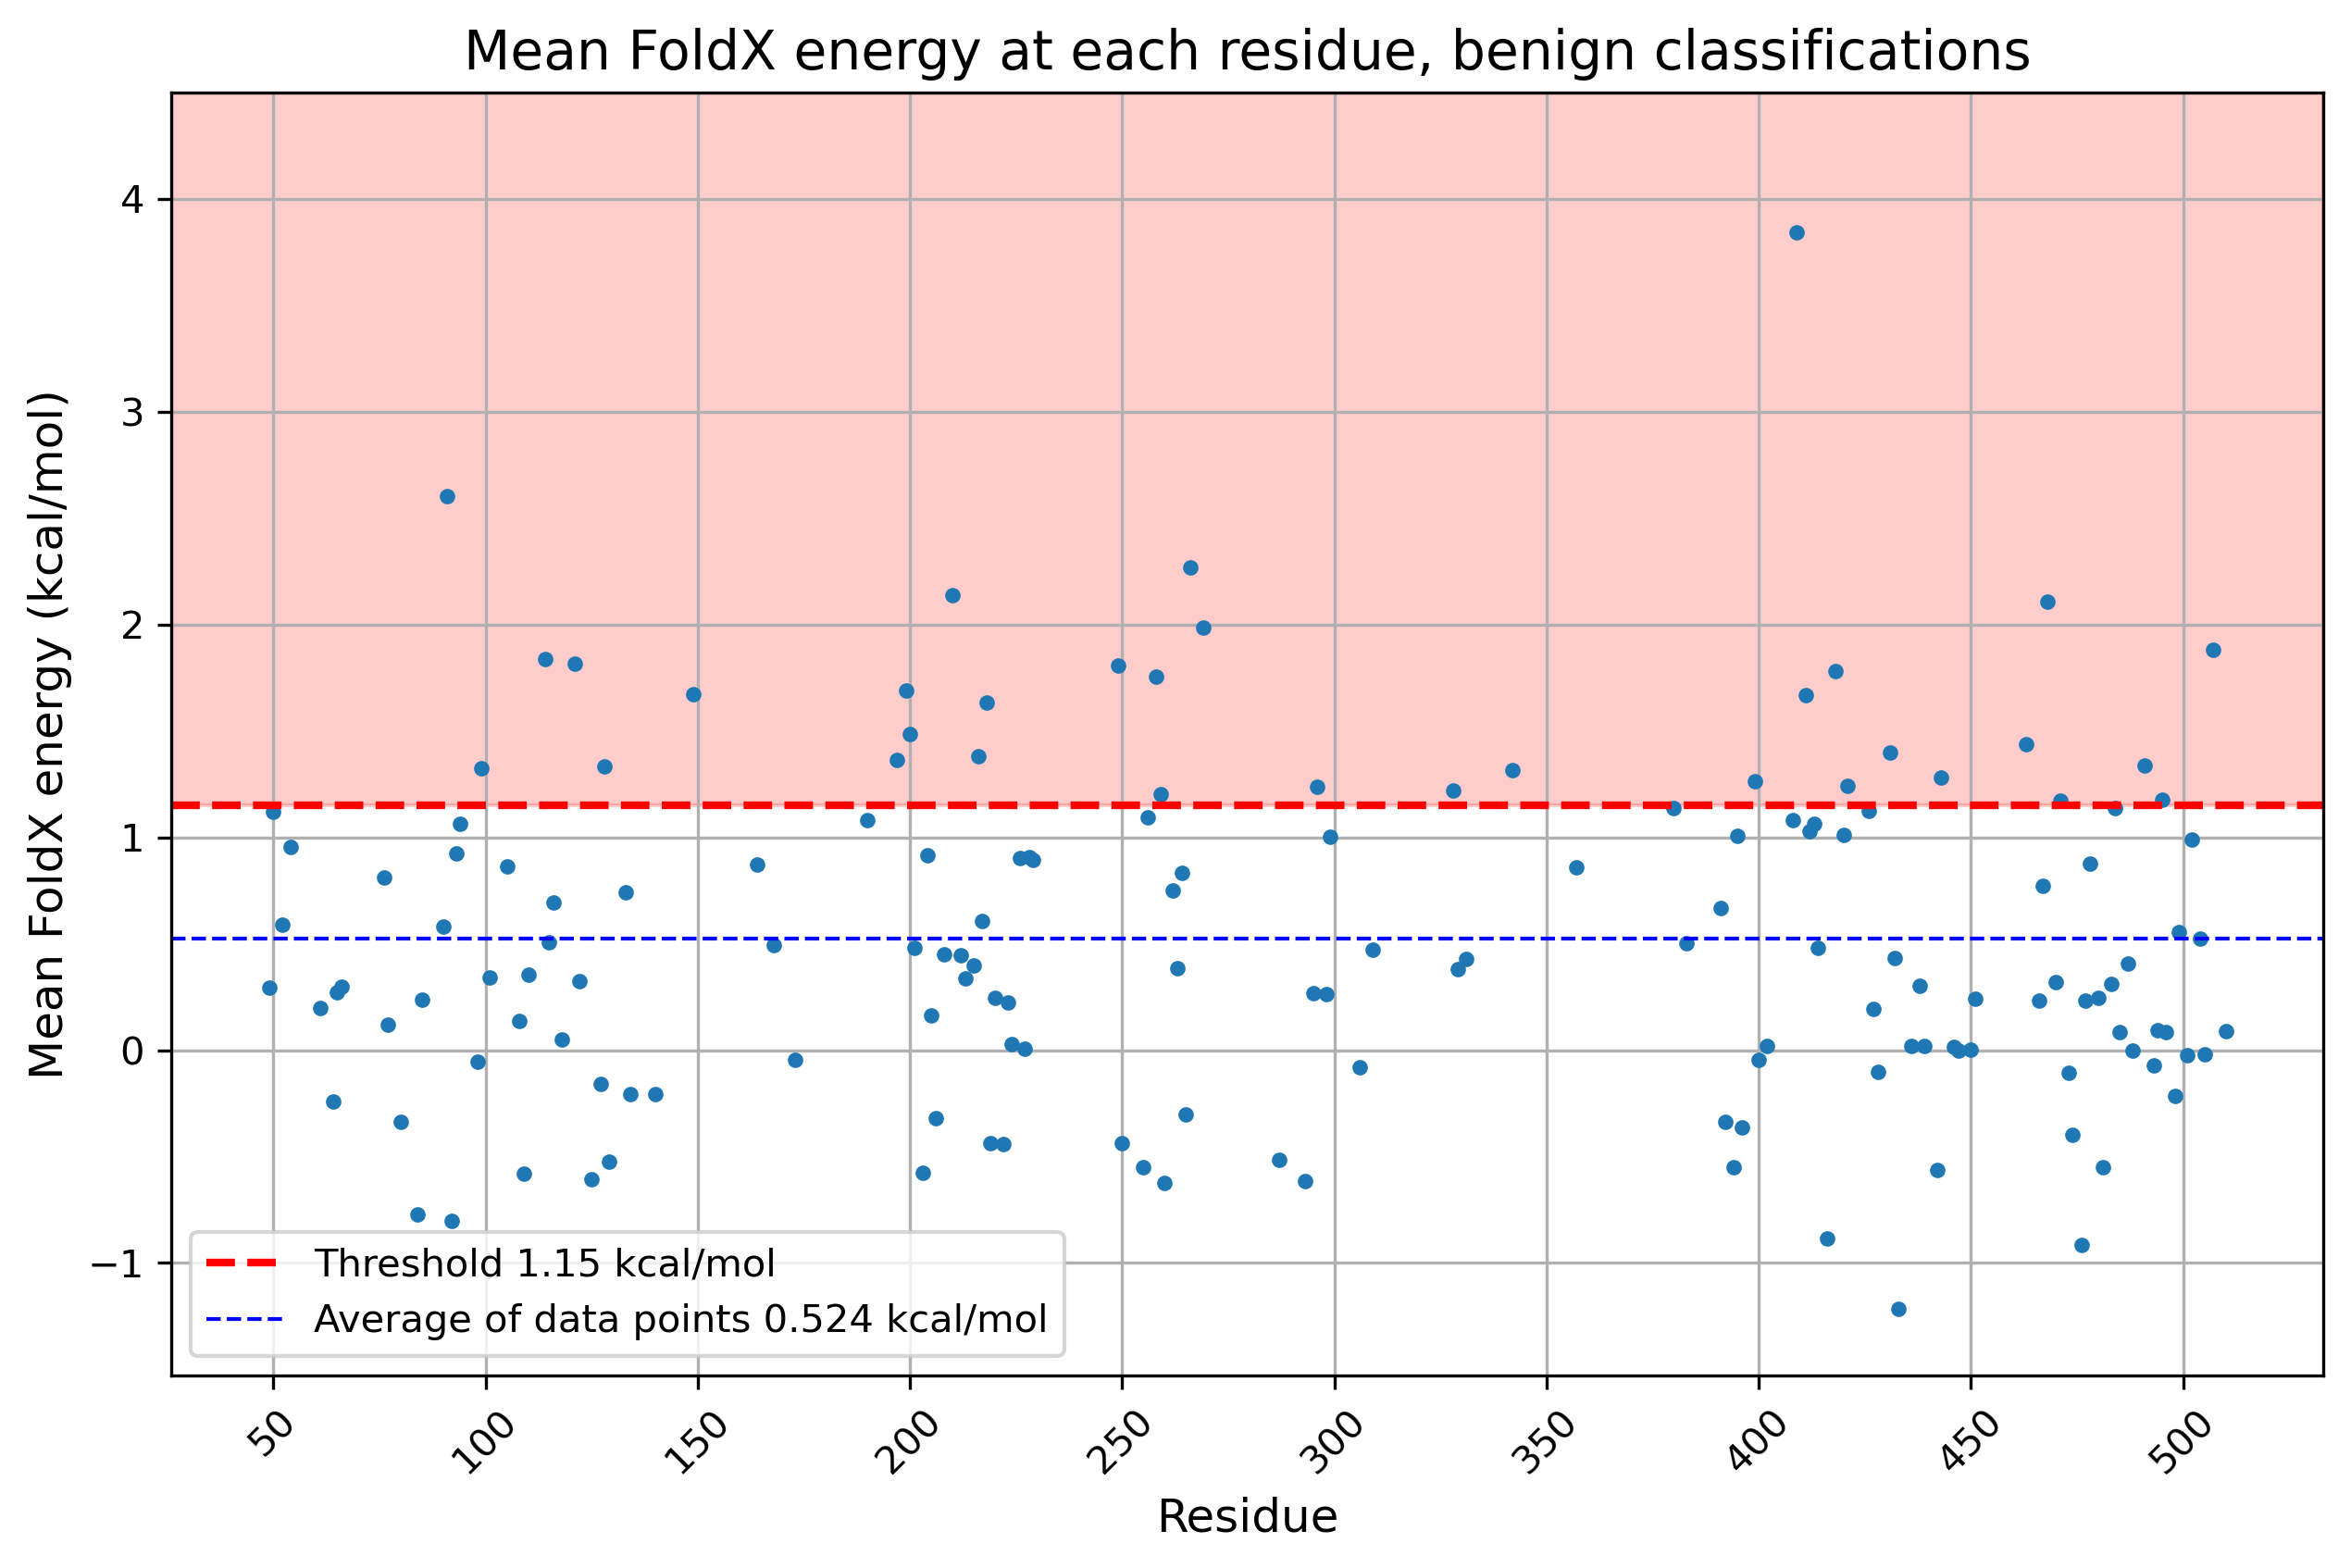

In [11]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["Foldx_energy"],'.')
# Cutoff horizontal line
plt.axhline(y=1.15, color="red", linestyle="--", linewidth=2, label="Threshold 1.15 kcal/mol")
plt.axhline(y=0.5238818822397322, color="blue",linestyle="--",linewidth=1,label="Average of data points 0.524 kcal/mol")
plt.axhspan(1.15,5, color="red", alpha=0.2)
plt.ylim(None,4.5)

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean FoldX energy (kcal/mol)", fontsize=12)
plt.title("Mean FoldX energy at each residue, benign classifications", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid()
plt.legend()
plt.show()

In [12]:
false_benign_Foldx = grouped_data[grouped_data["Foldx_energy"] >= 1.15]

print(len(false_benign_Foldx))
print(len(grouped_data))

33
160


In [13]:
# Group by residue, averaging energies
grouped_data = ds_calc.groupby("Residue", as_index=False)["Foldx_energy"].mean()

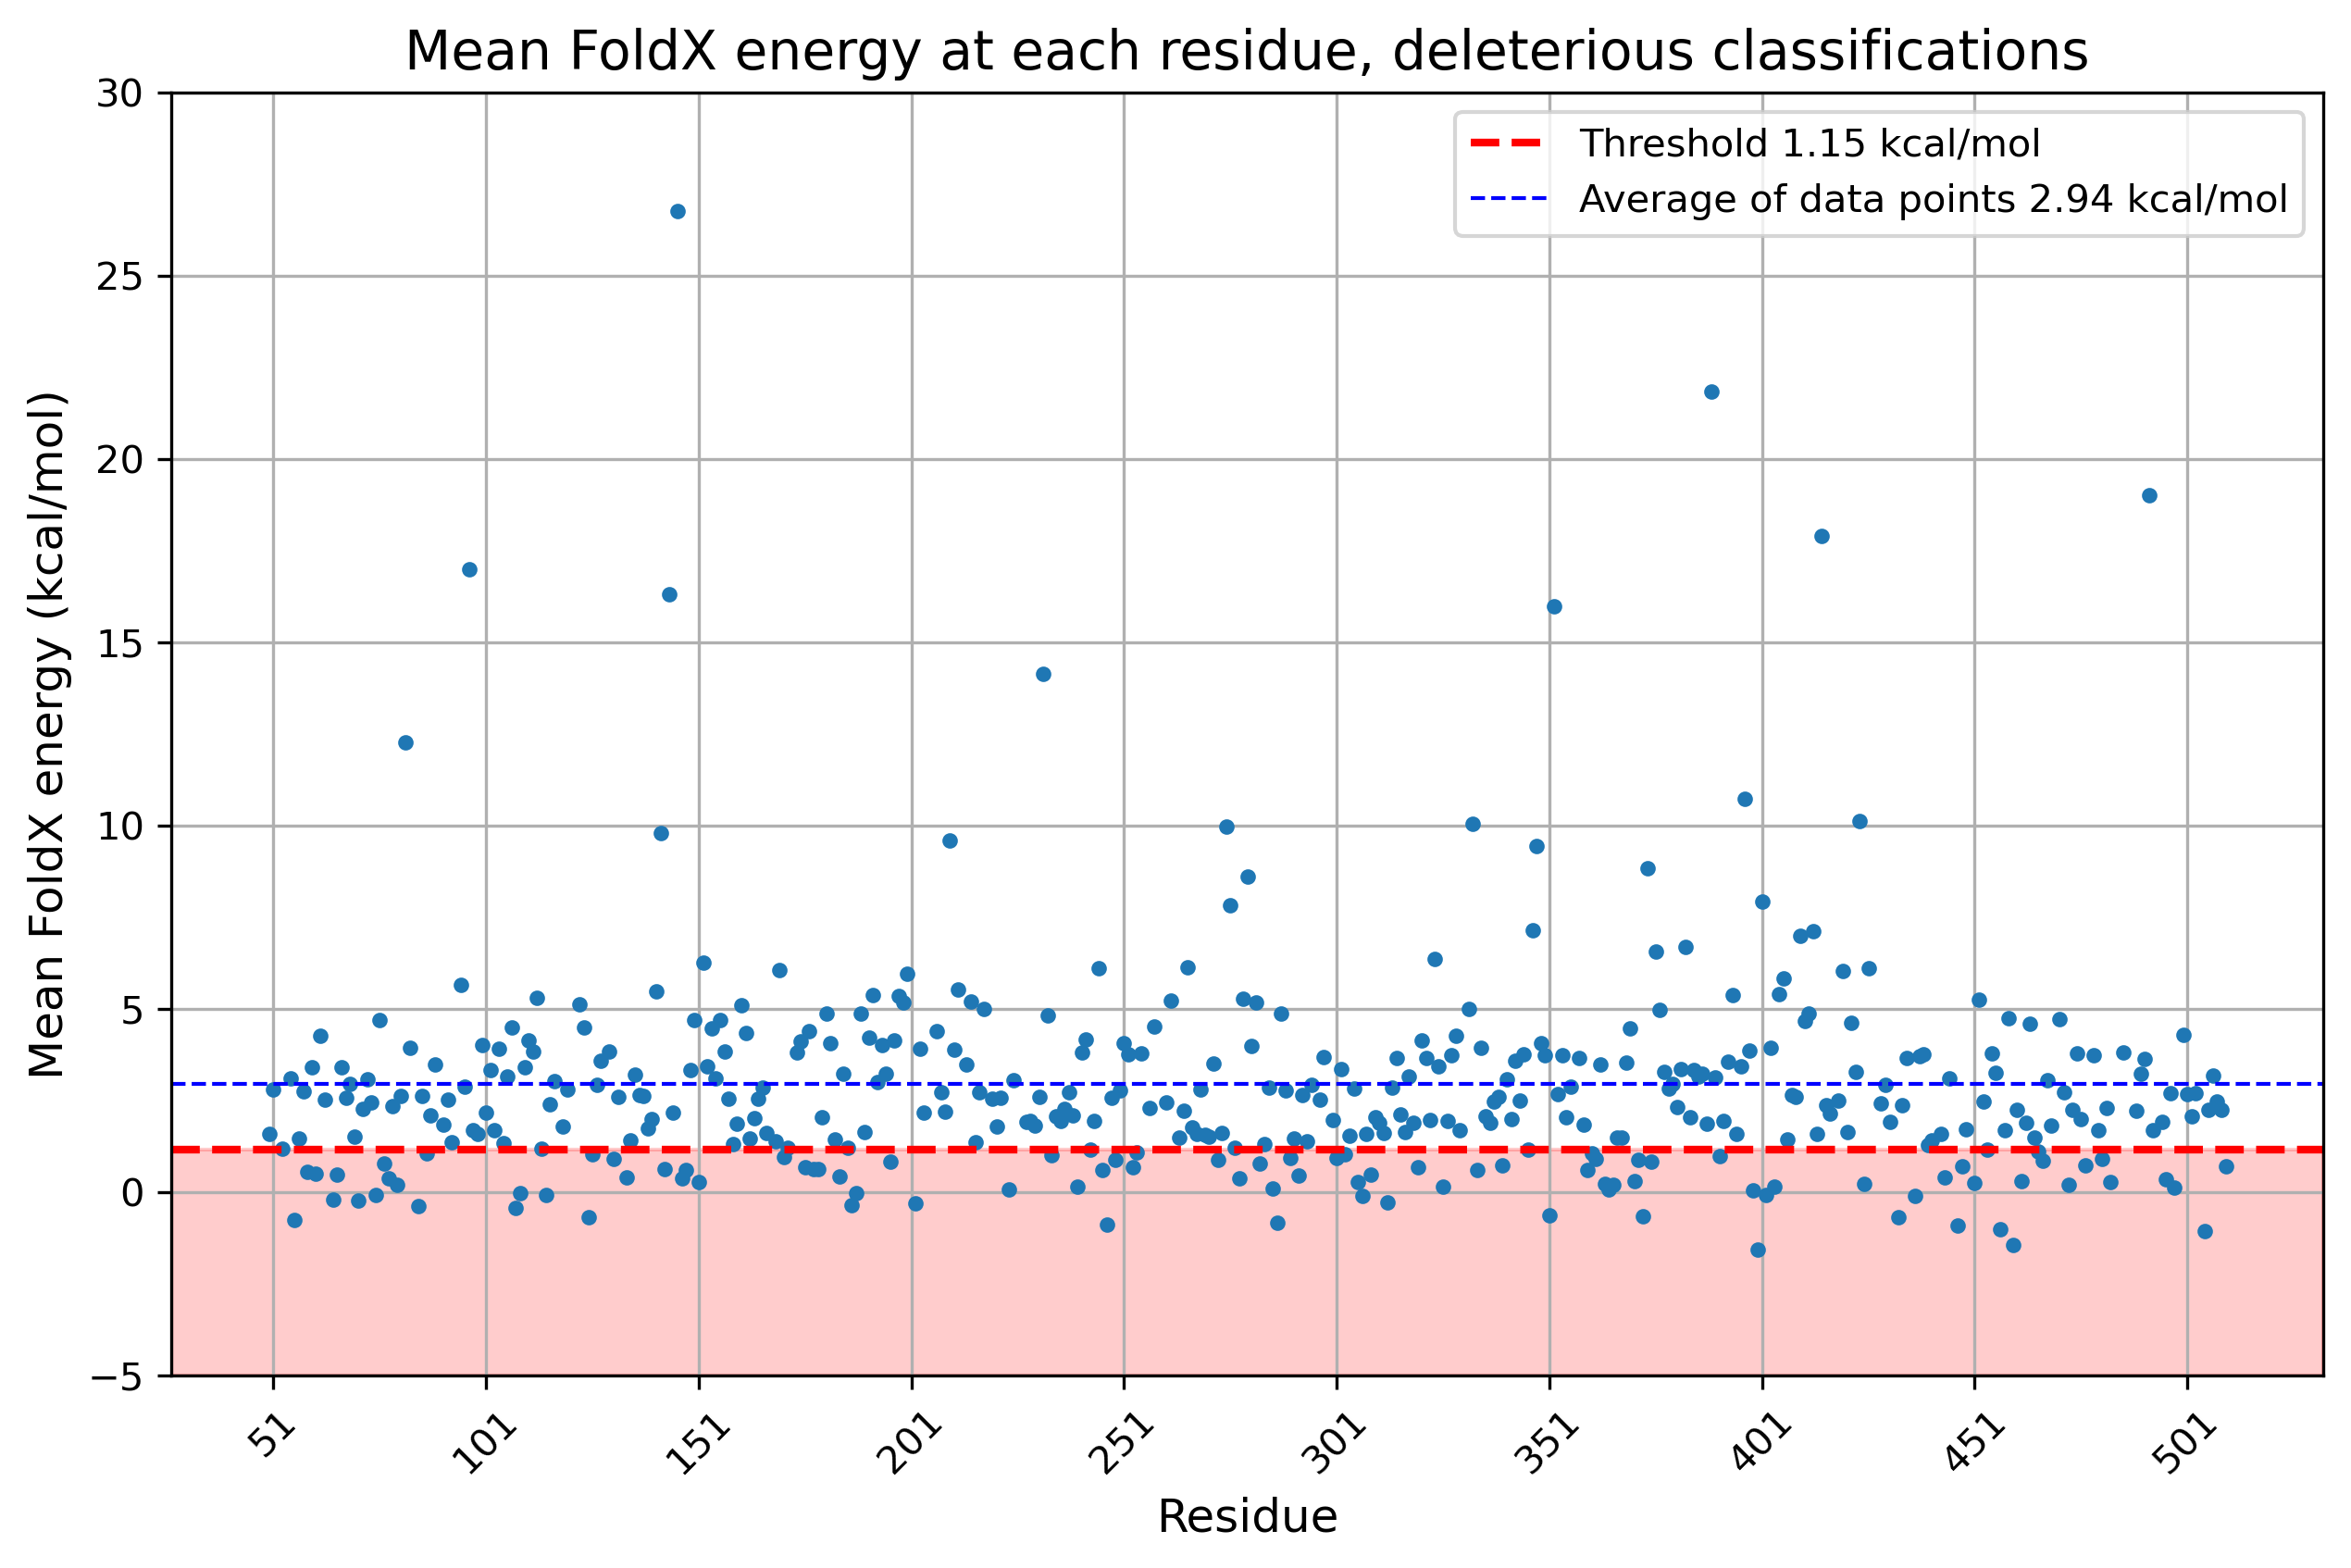

In [14]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["Foldx_energy"],'.')
# Cutoff horizontal line
plt.axhline(y=1.15, color="red", linestyle="--", linewidth=2,label="Threshold 1.15 kcal/mol")
plt.axhline(y=2.9374536874713715, color="blue",linestyle="--",linewidth=1,label="Average of data points 2.94 kcal/mol")
plt.axhspan(-5,1.15, color="red", alpha=0.2)
plt.ylim(-5,30)

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean FoldX energy (kcal/mol)", fontsize=12)
plt.title("Mean FoldX energy at each residue, deleterious classifications", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid(True)
plt.legend()
plt.show()

In [15]:
false_deleterious_Foldx = grouped_data[grouped_data["Foldx_energy"] <= 1.15]

print(len(false_deleterious_Foldx))
print(len(grouped_data))

94
415


Unrelated but we can see lots of residues have a very high mean FoldX energy - possible hotspots?

In [16]:
StatisticalScores_calc[["Residue","Foldx_energy"]]
# Group by residue, averaging energies
grouped_data = StatisticalScores_calc.groupby("Residue", as_index=False)["Foldx_energy"].mean()

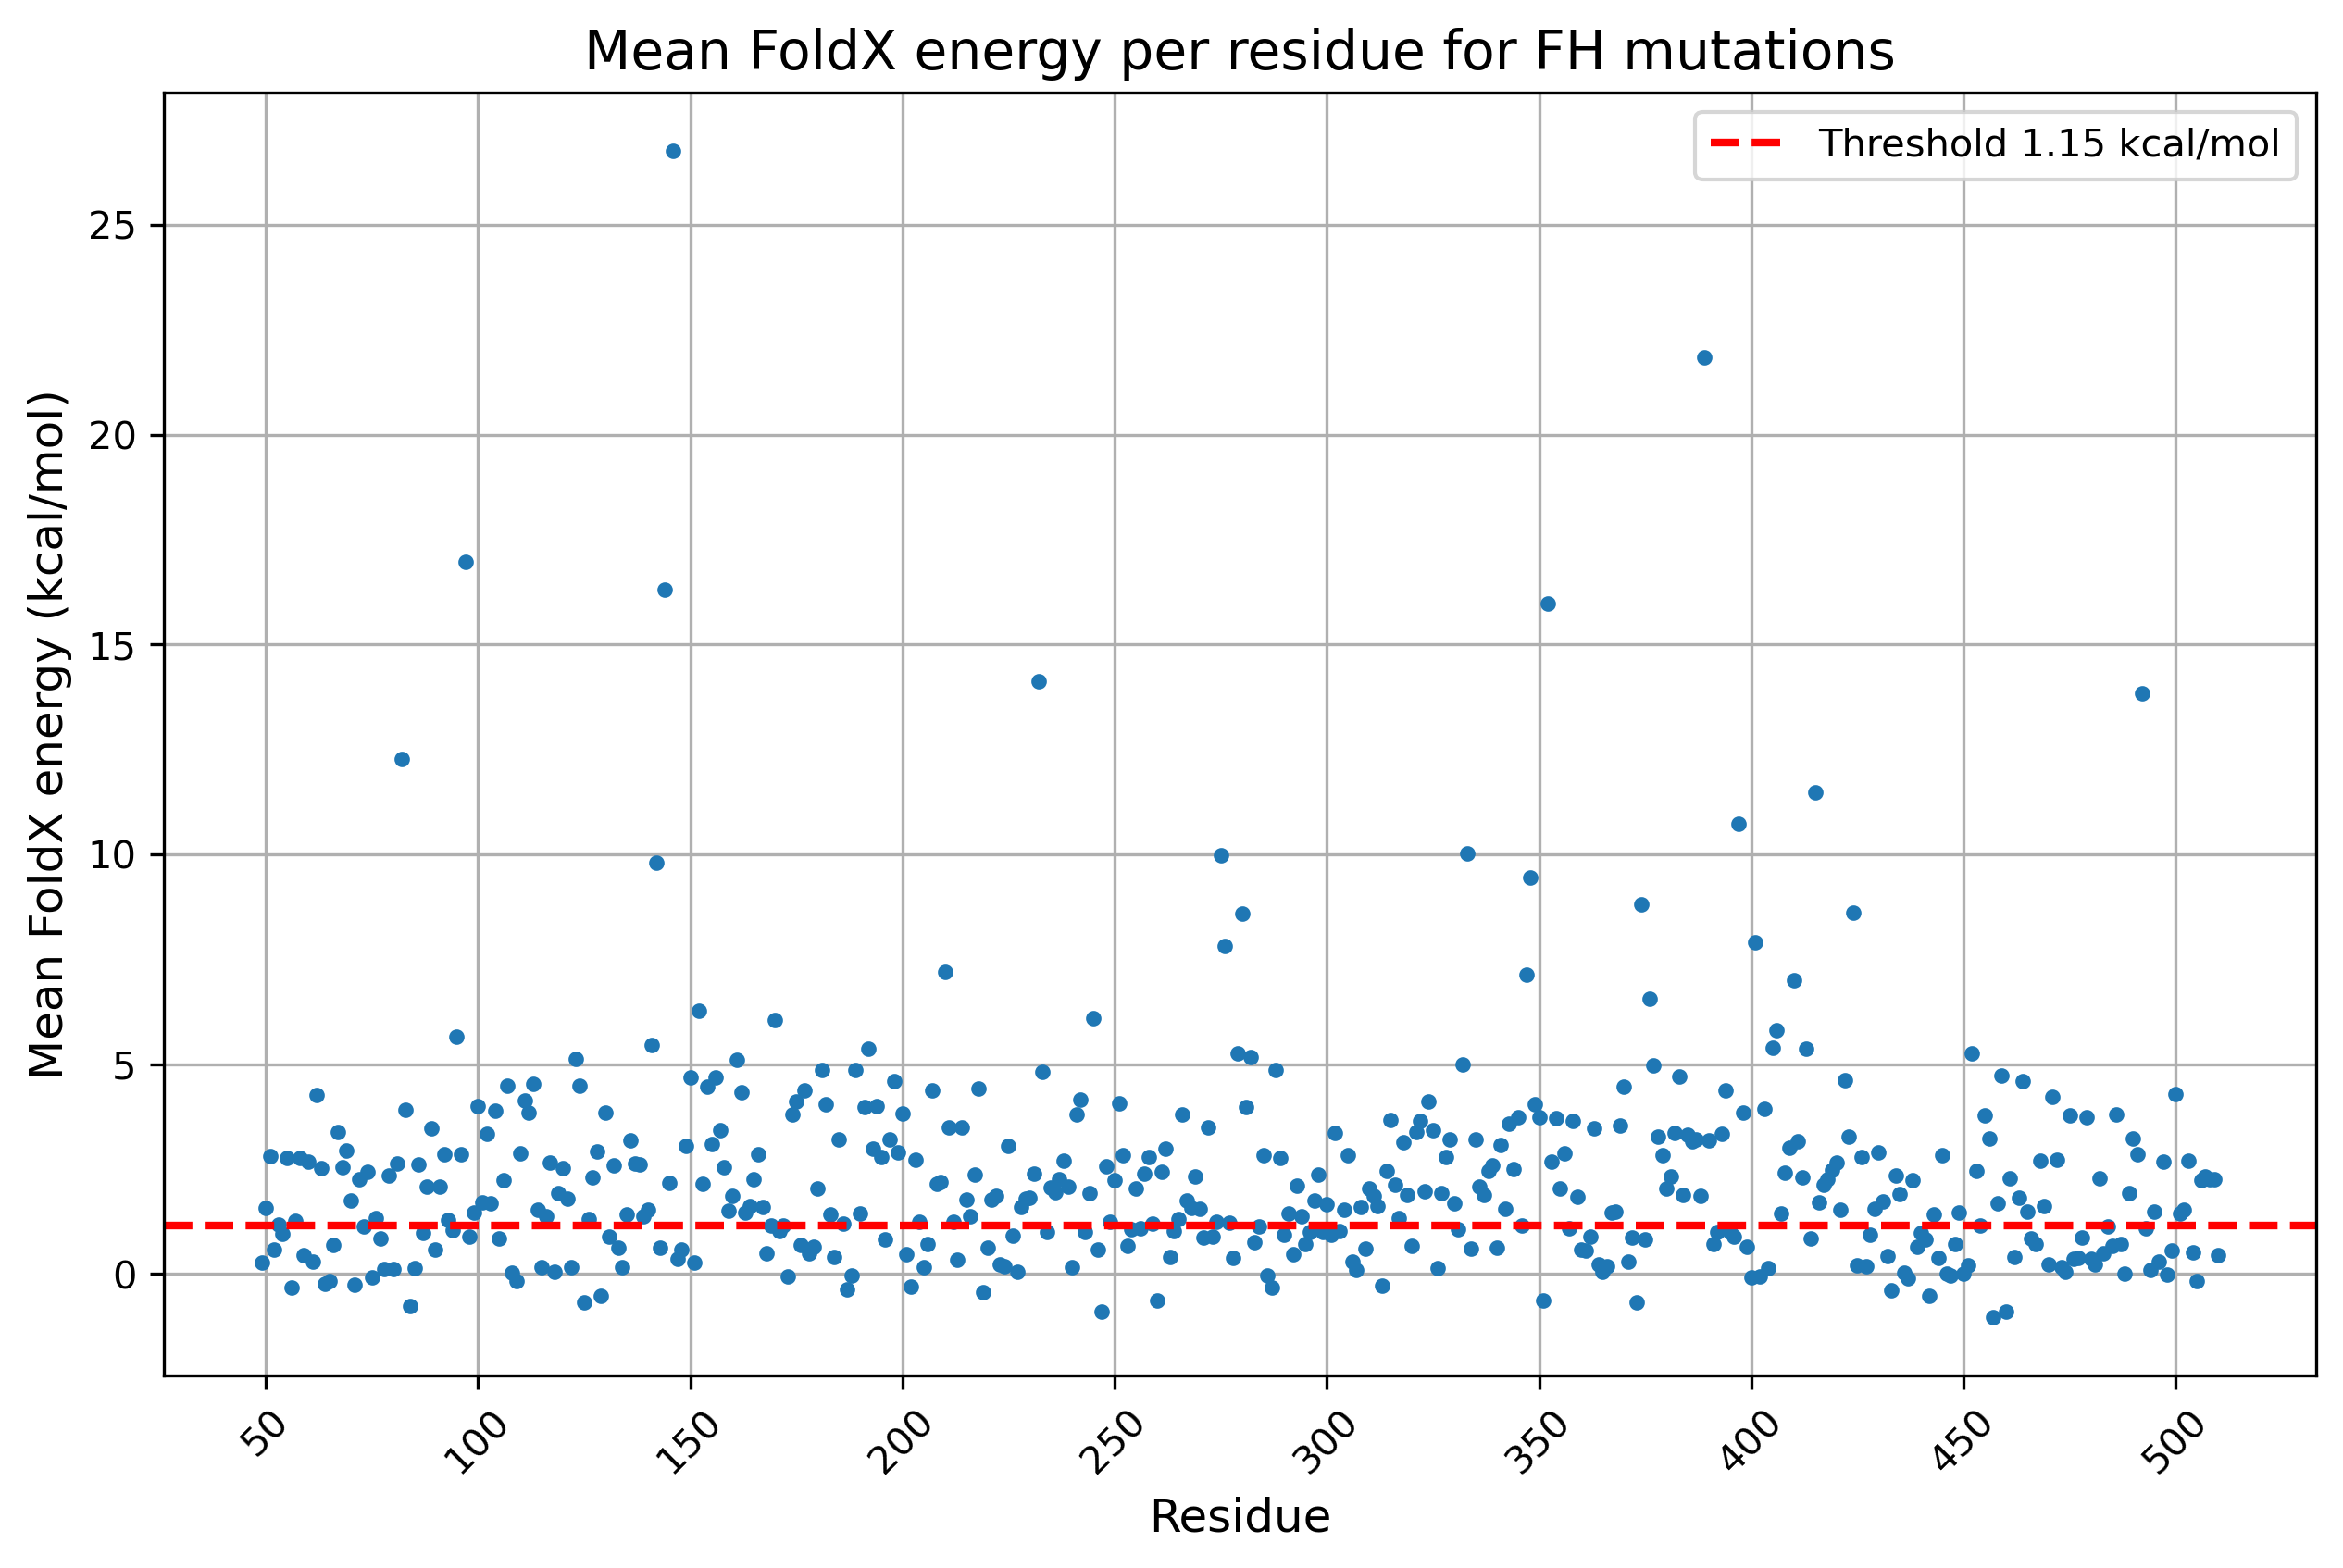

In [17]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["Foldx_energy"],'.')
# Cutoff horizontal line
plt.axhline(y=1.15, color="red", linestyle="--", linewidth=2,label="Threshold 1.15 kcal/mol")

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean FoldX energy (kcal/mol)", fontsize=12)
plt.title("Mean FoldX energy per residue for FH mutations", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid(True)
plt.legend()
plt.show()

In [18]:
# Group by residue for RSA
grouped_data = ds_calc.groupby("Residue", as_index=False)["RSA"].mean()

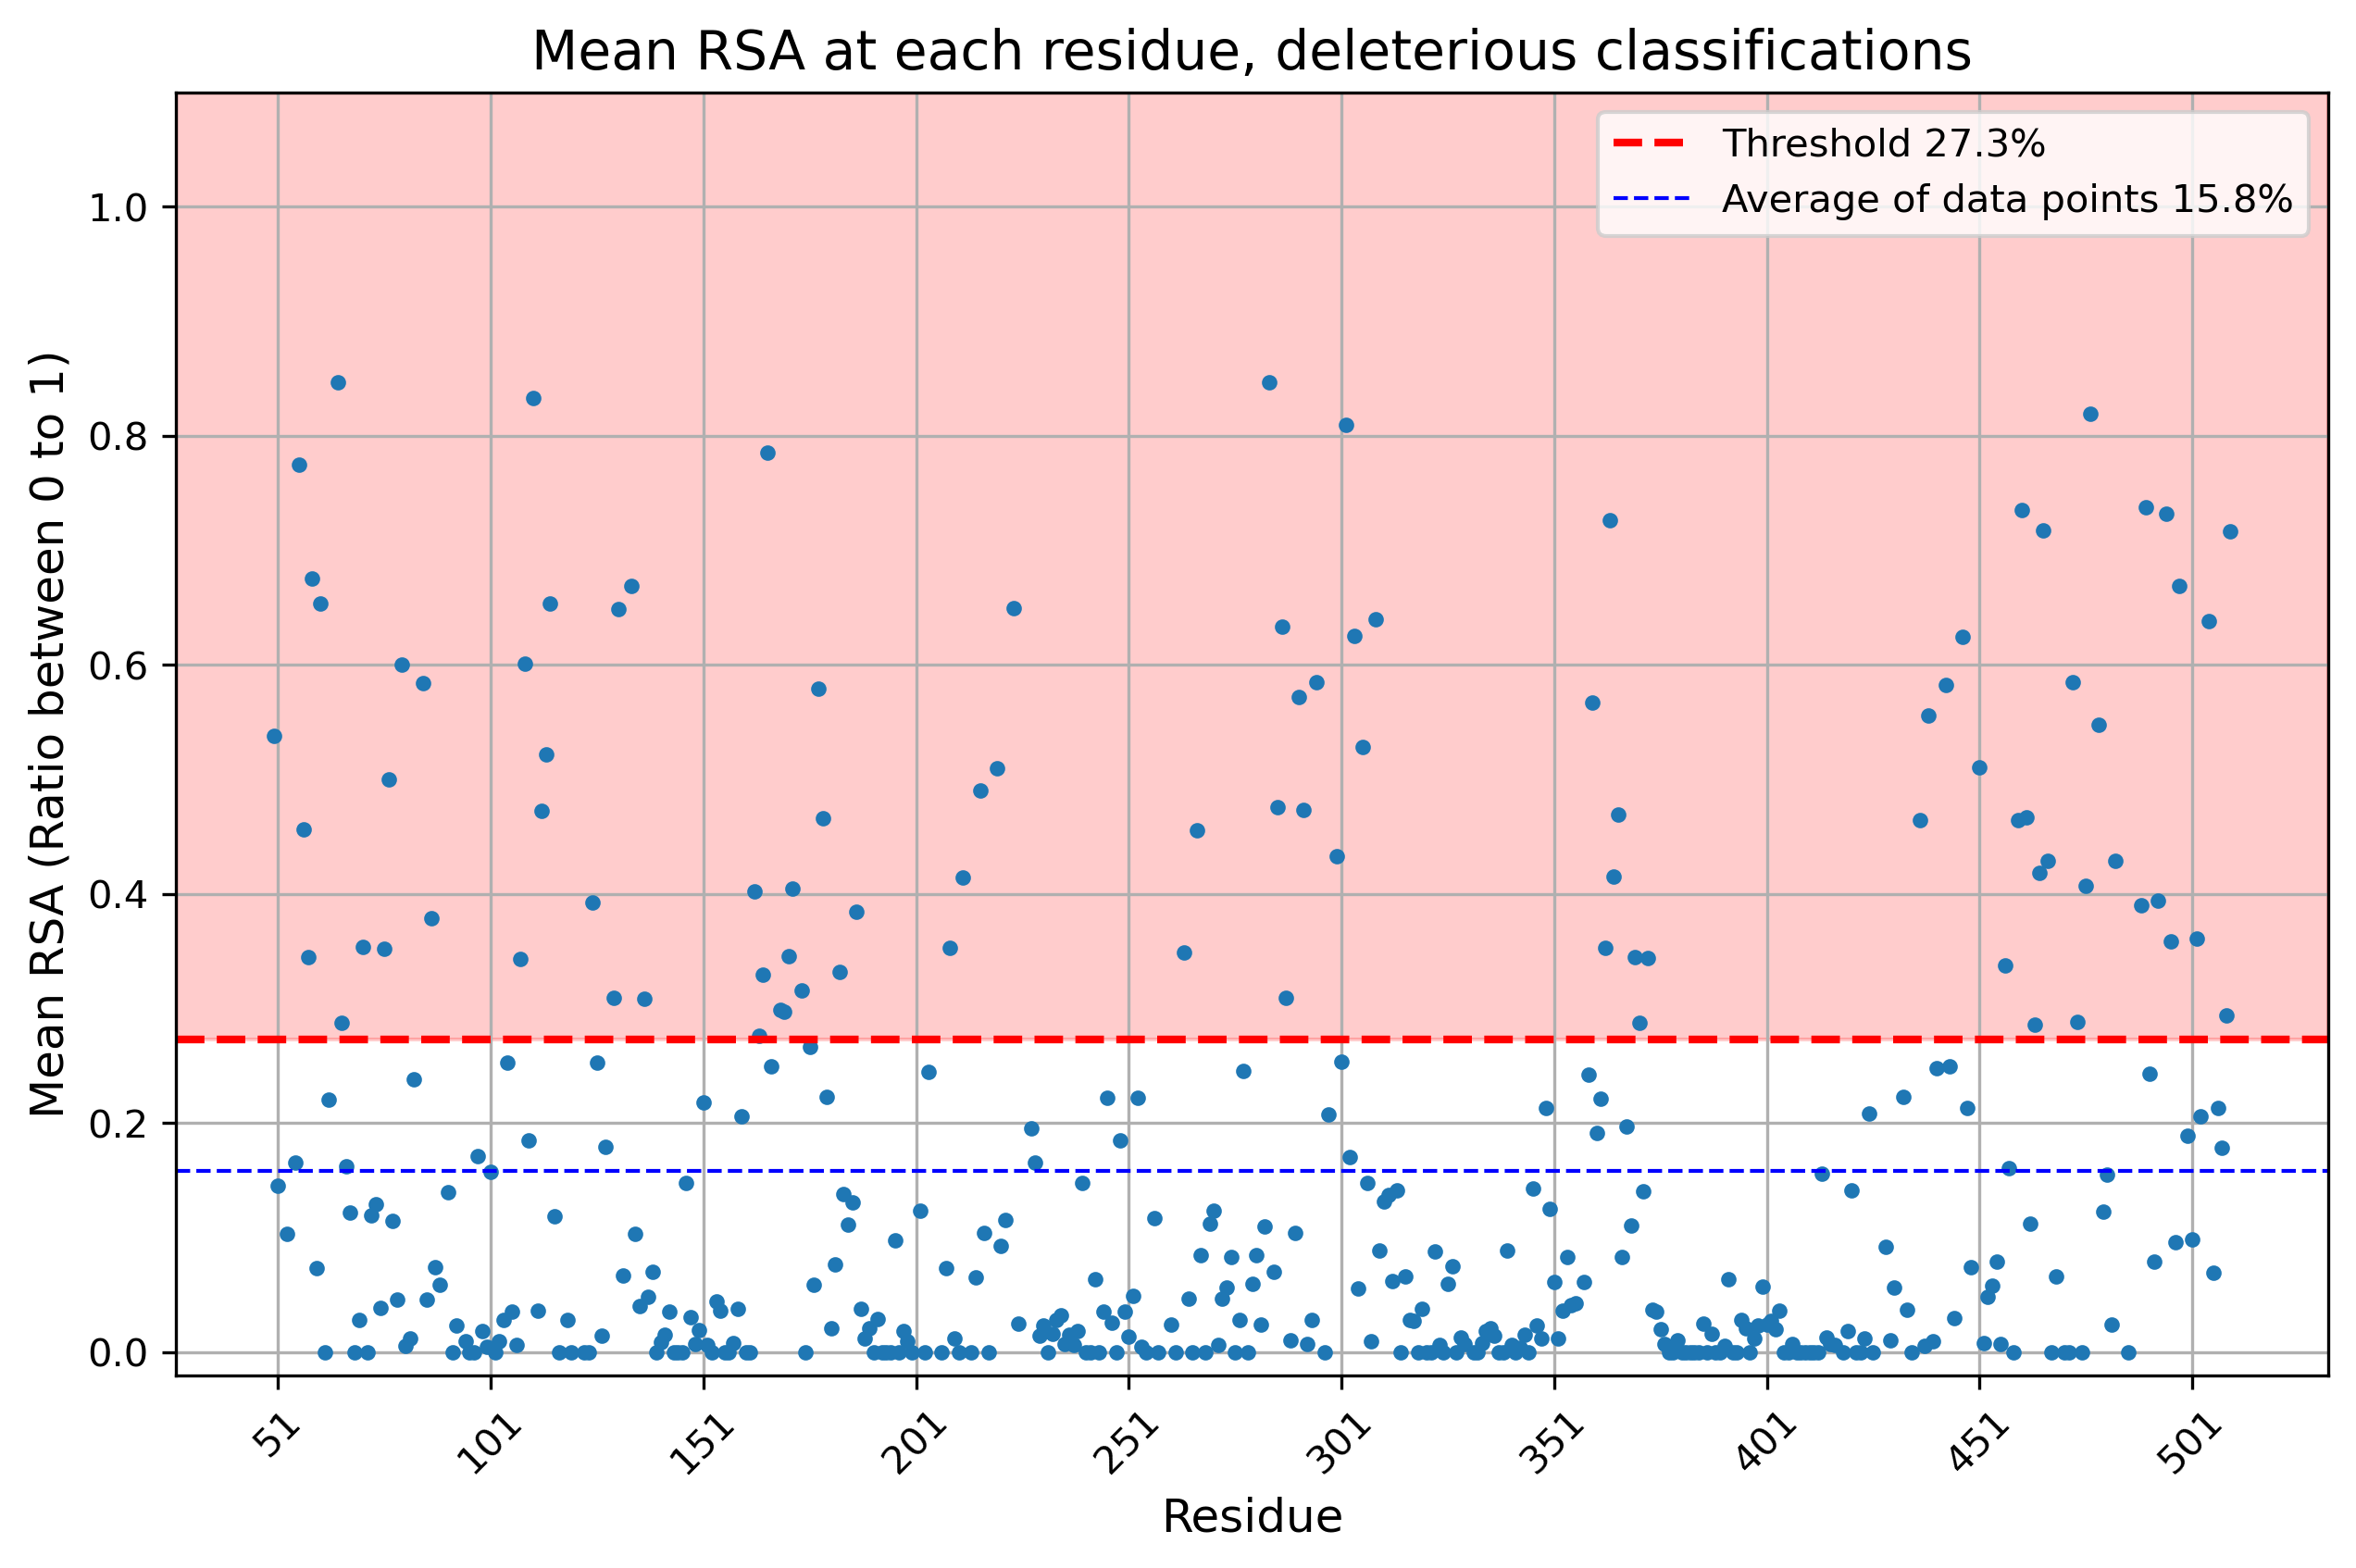

In [19]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["RSA"],'.')
# Cutoff horizontal line
plt.axhline(y=0.273, color="red", linestyle="--", linewidth=2,label="Threshold 27.3%")
plt.axhline(y=0.15799435877108434, color="blue",linestyle="--",linewidth=1,label="Average of data points 15.8%")
plt.axhspan(0.273,1.1, color="red", alpha=0.2)
plt.ylim(-0.02,1.1)

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean RSA (Ratio between 0 to 1)", fontsize=12)
plt.title("Mean RSA at each residue, deleterious classifications", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid(True)
plt.legend()
plt.show()

In [20]:
false_deleterious_RSA = grouped_data[grouped_data["RSA"] >= 0.273]

print(len(false_deleterious_RSA))
print(len(grouped_data))

94
415


In [21]:
# Group by residue for RSA
grouped_data = bs_calc.groupby("Residue", as_index=False)["RSA"].mean()

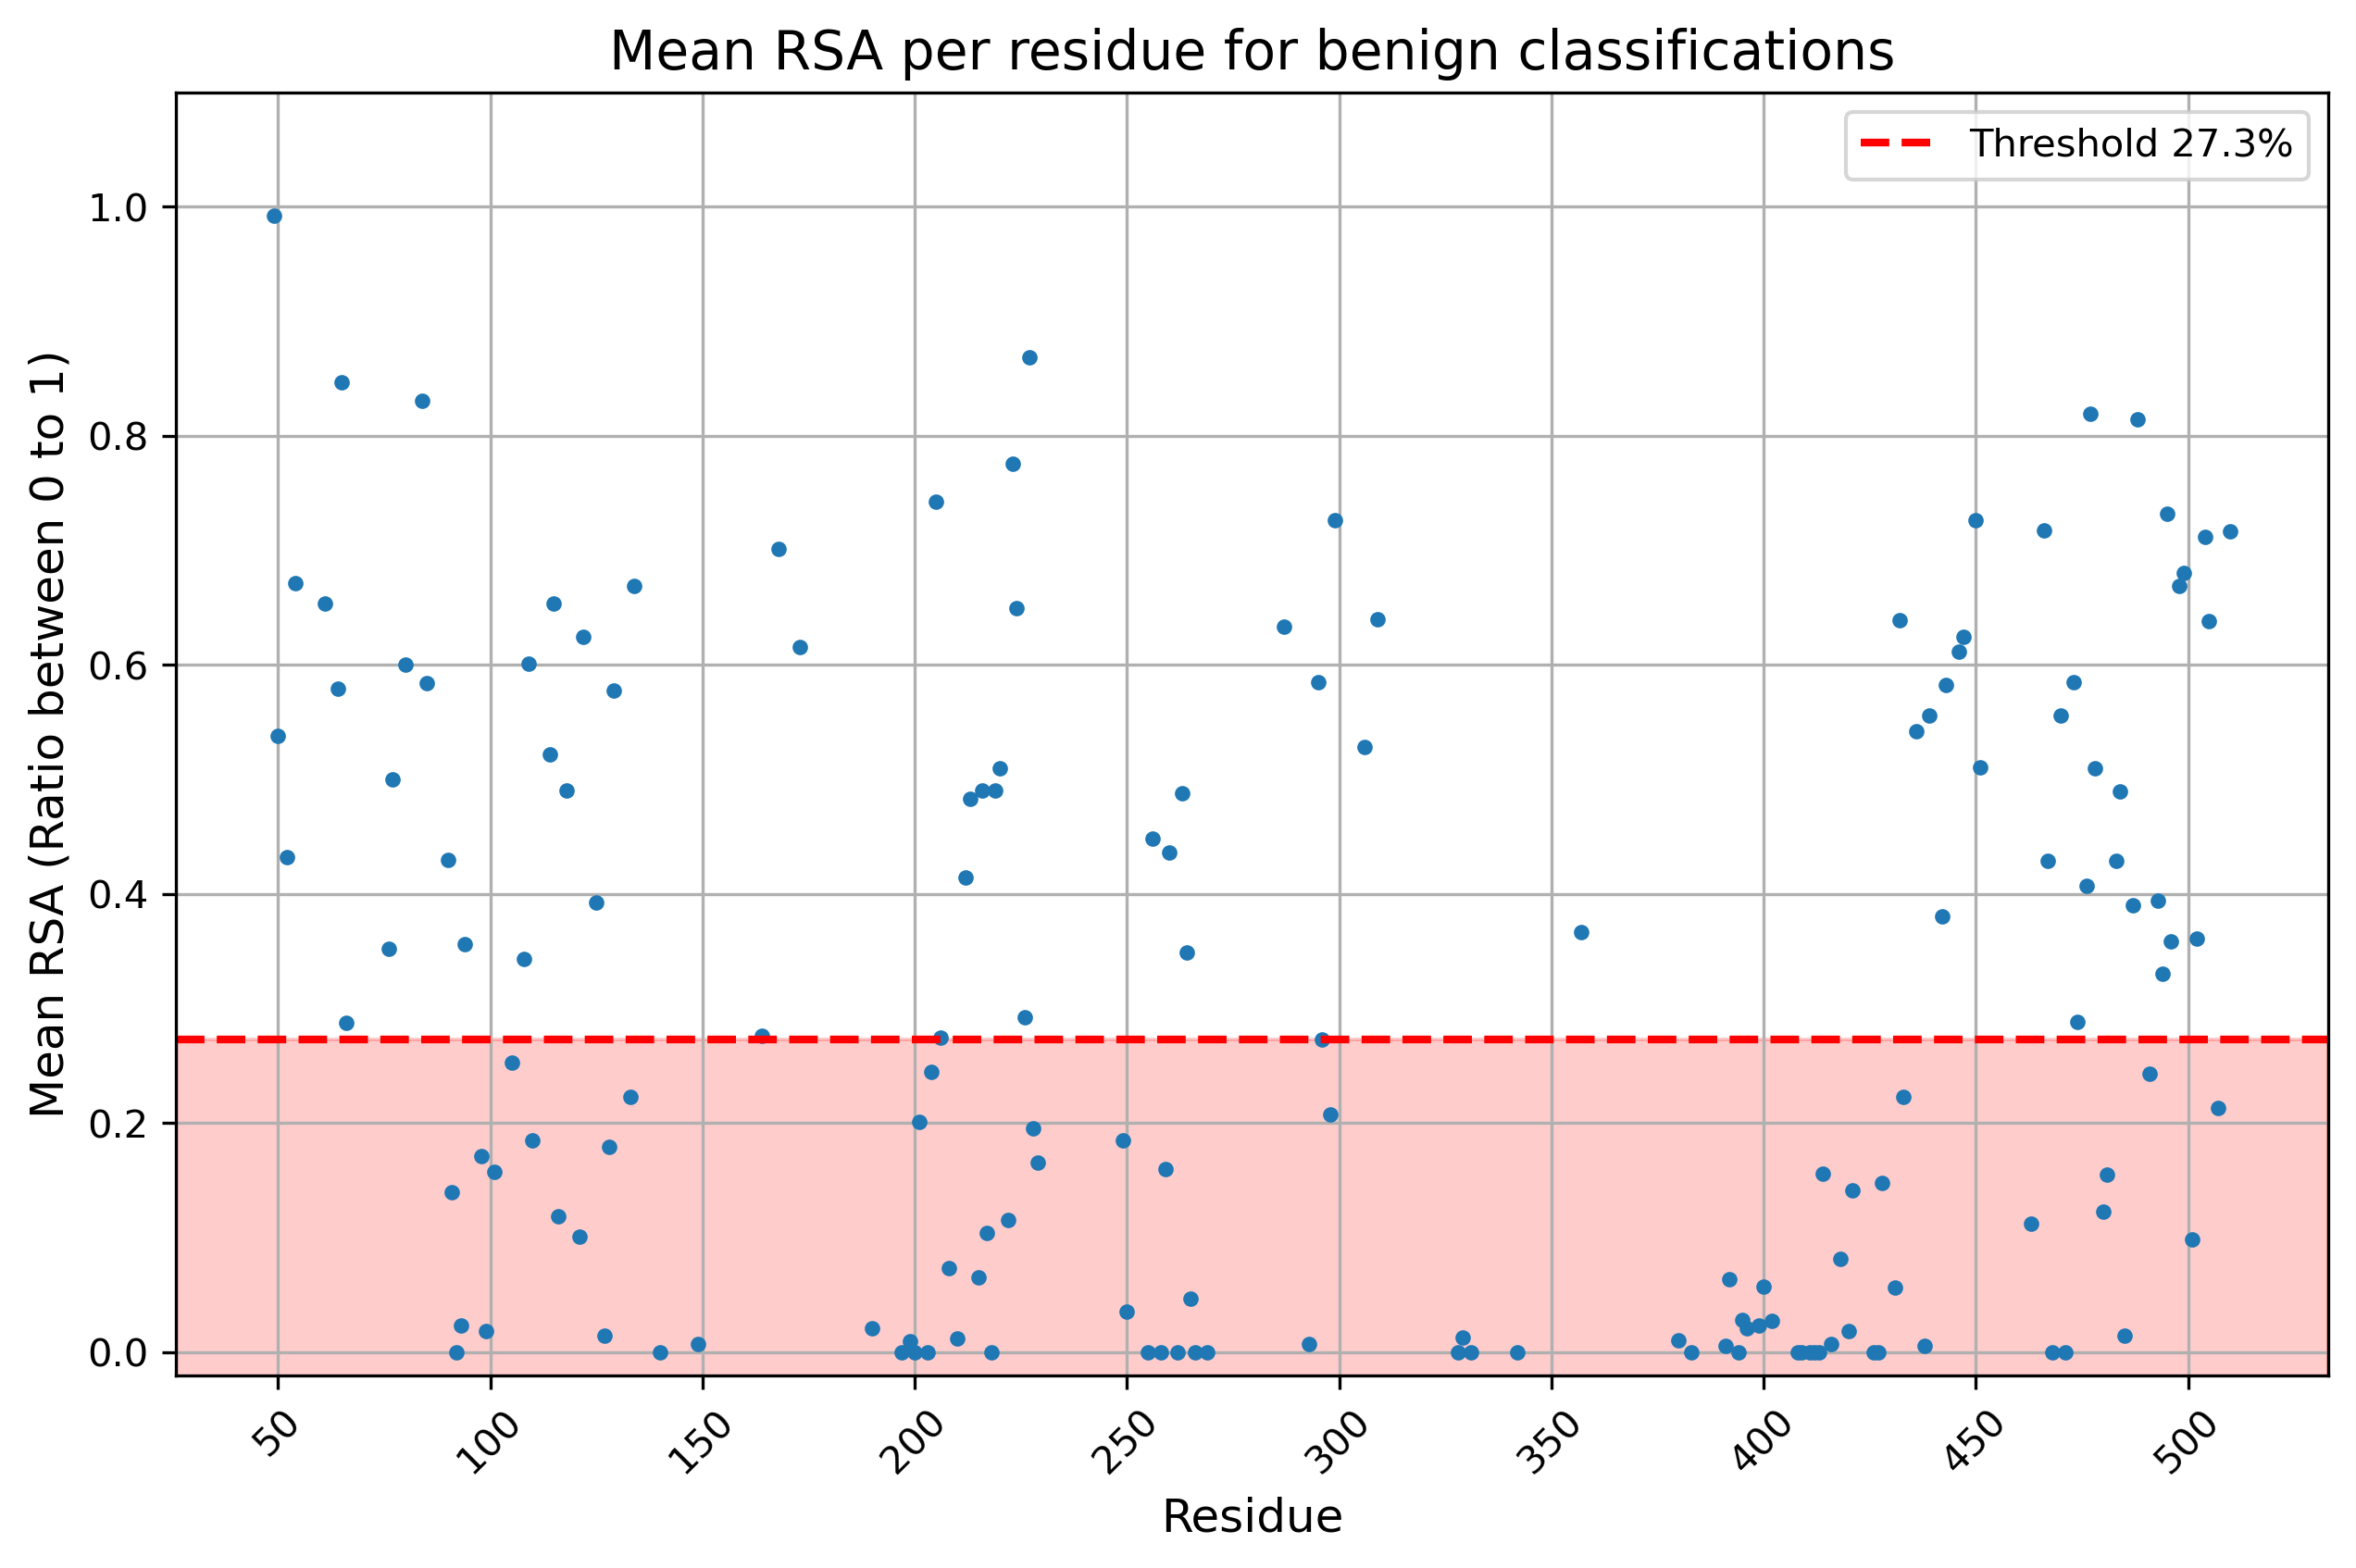

In [22]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["RSA"],'.')
# Cutoff horizontal line
plt.axhline(y=0.273, color="red", linestyle="--", linewidth=2,label="Threshold 27.3%")
plt.axhspan(-0.5,0.273, color="red", alpha=0.2)
plt.ylim(-0.02,1.1)

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean RSA (Ratio between 0 to 1)", fontsize=12)
plt.title("Mean RSA per residue for benign classifications", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid(True)
plt.legend()
plt.show()

In [23]:
grouped_data = ds_calc.groupby("Residue", as_index=False)["Mindist_bindingsiteA"].mean()

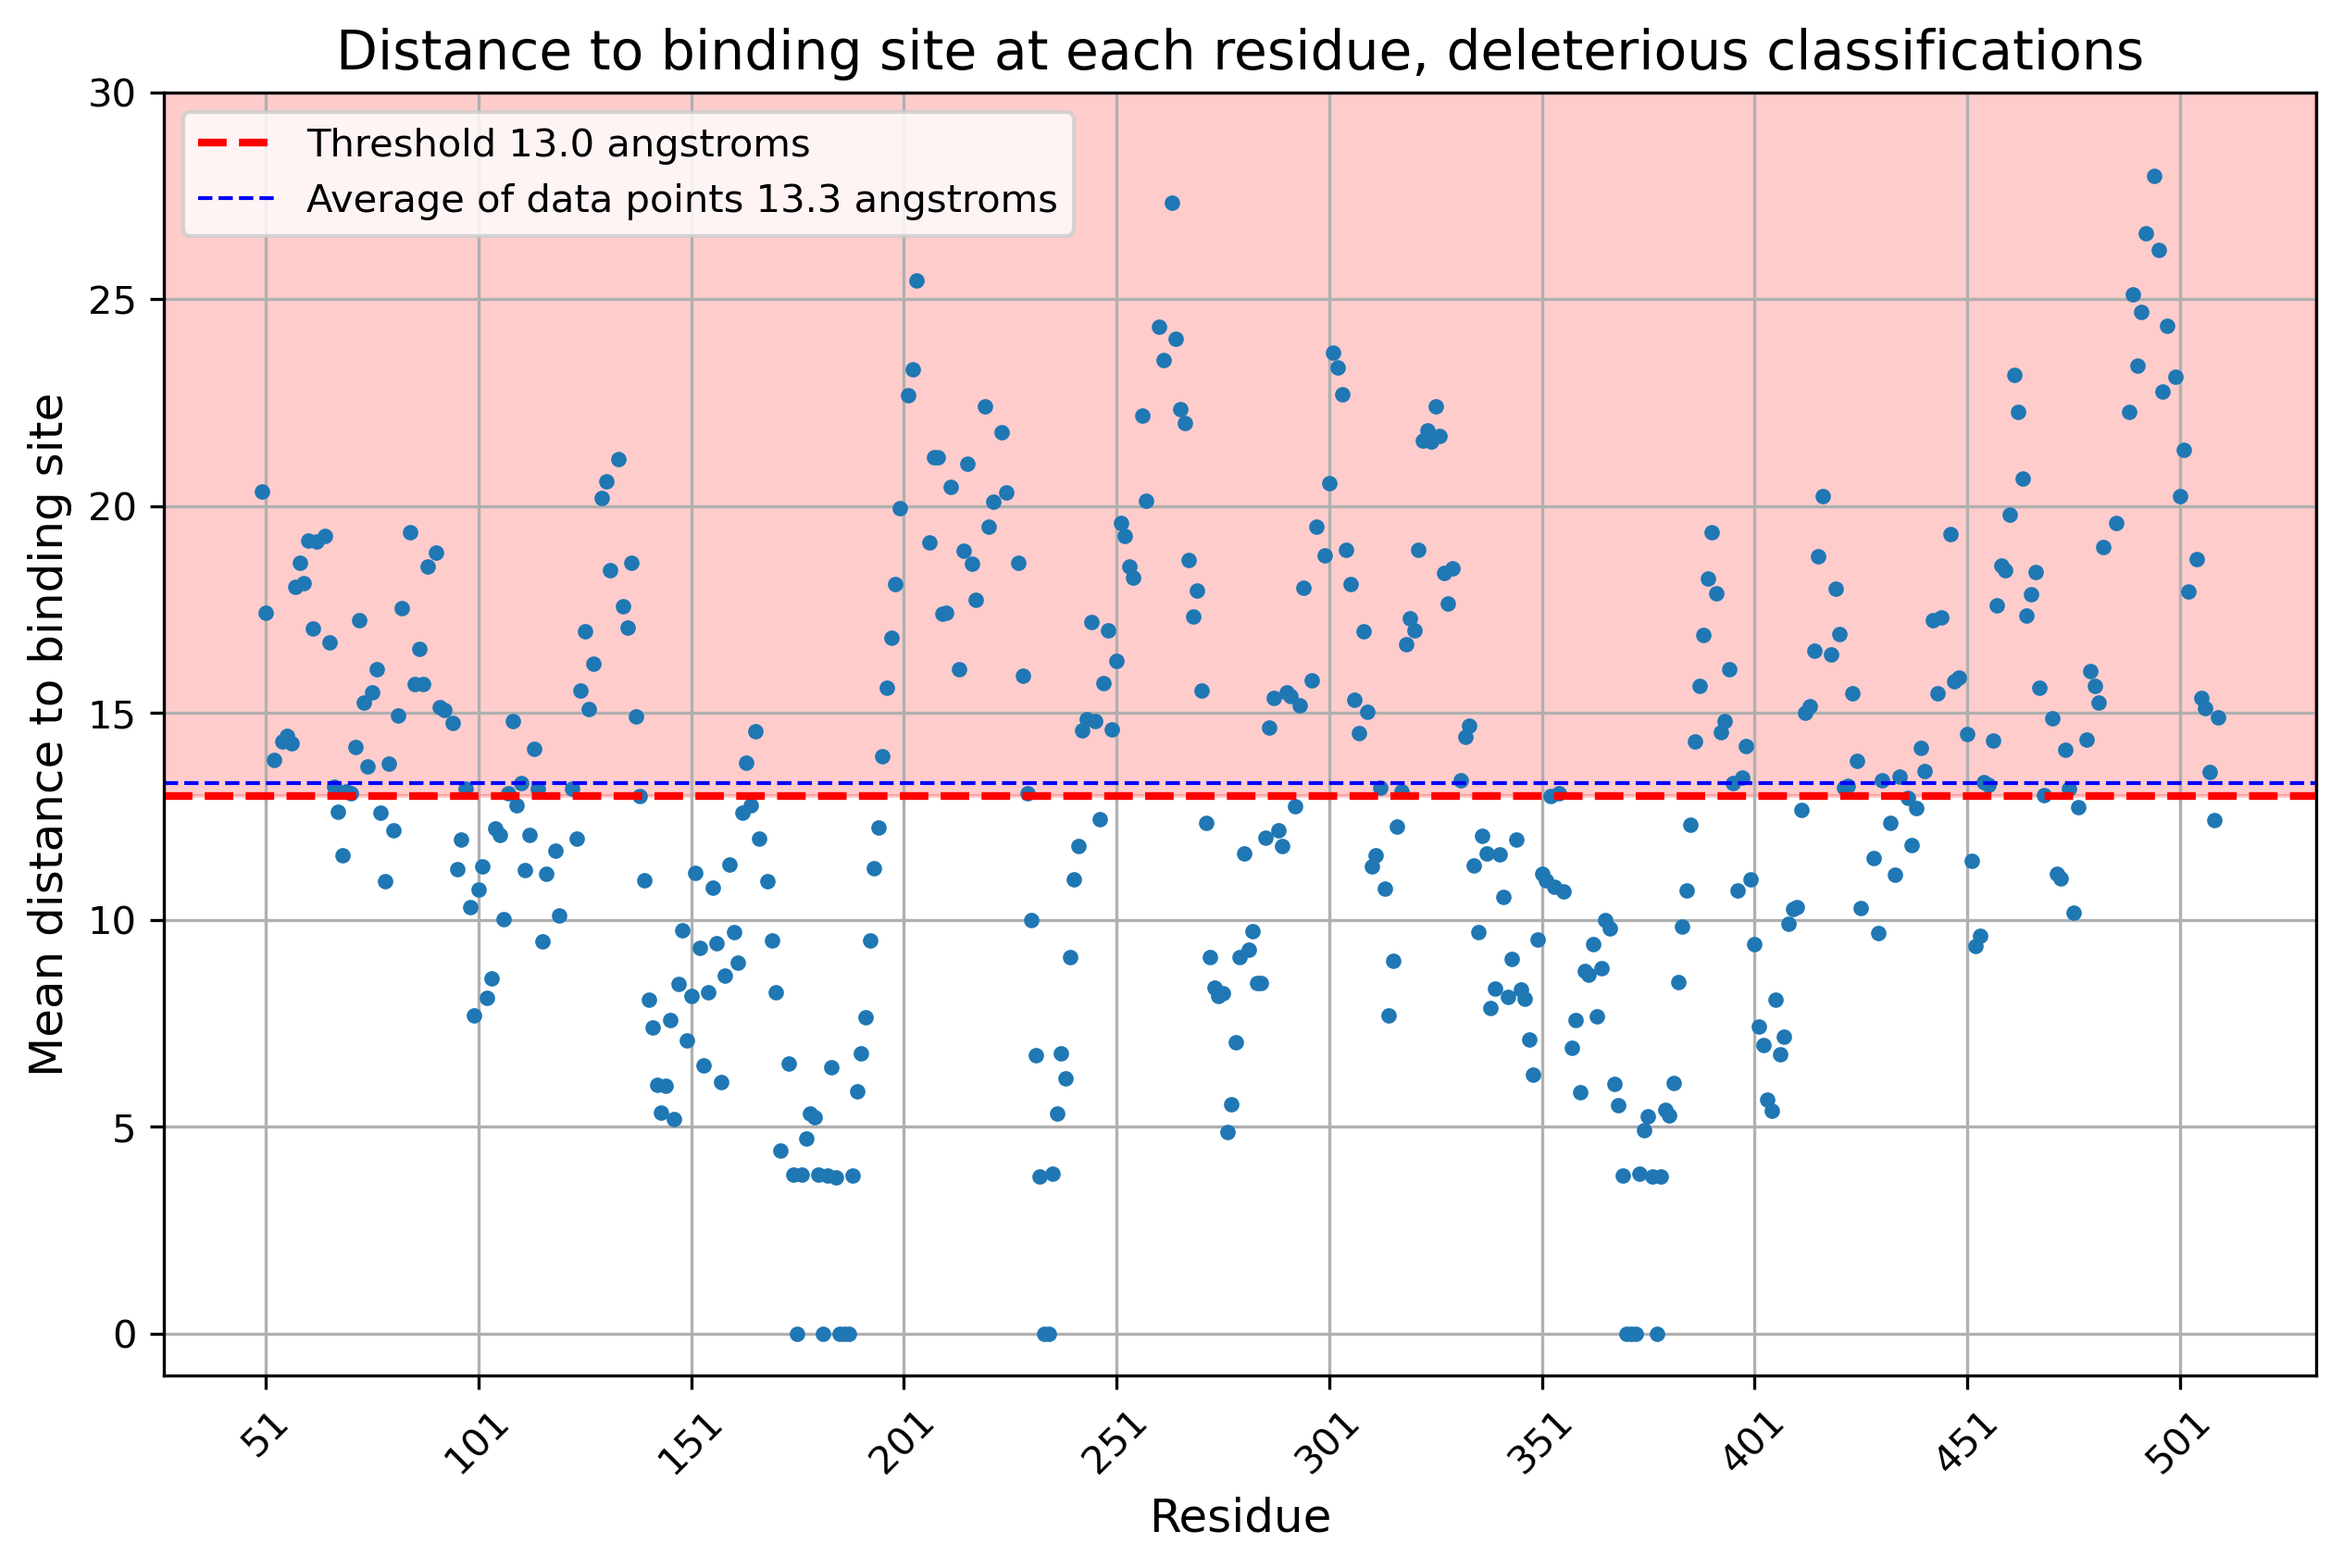

In [24]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["Mindist_bindingsiteA"],'.')
# Cutoff horizontal line
plt.axhline(y=13.0, color="red", linestyle="--", linewidth=2,label="Threshold 13.0 angstroms")
plt.axhline(y=13.300927438503614, color="blue",linestyle="--",linewidth=1,label="Average of data points 13.3 angstroms")
plt.axhspan(13.0,50, color="red", alpha=0.2)
plt.ylim(-1,30)

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean distance to binding site", fontsize=12)
plt.title("Distance to binding site at each residue, deleterious classifications", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid(True)
plt.legend()
plt.show()

In [25]:
grouped_data = ds_calc.groupby("Residue", as_index=False)["Mindist_hinge"].mean()

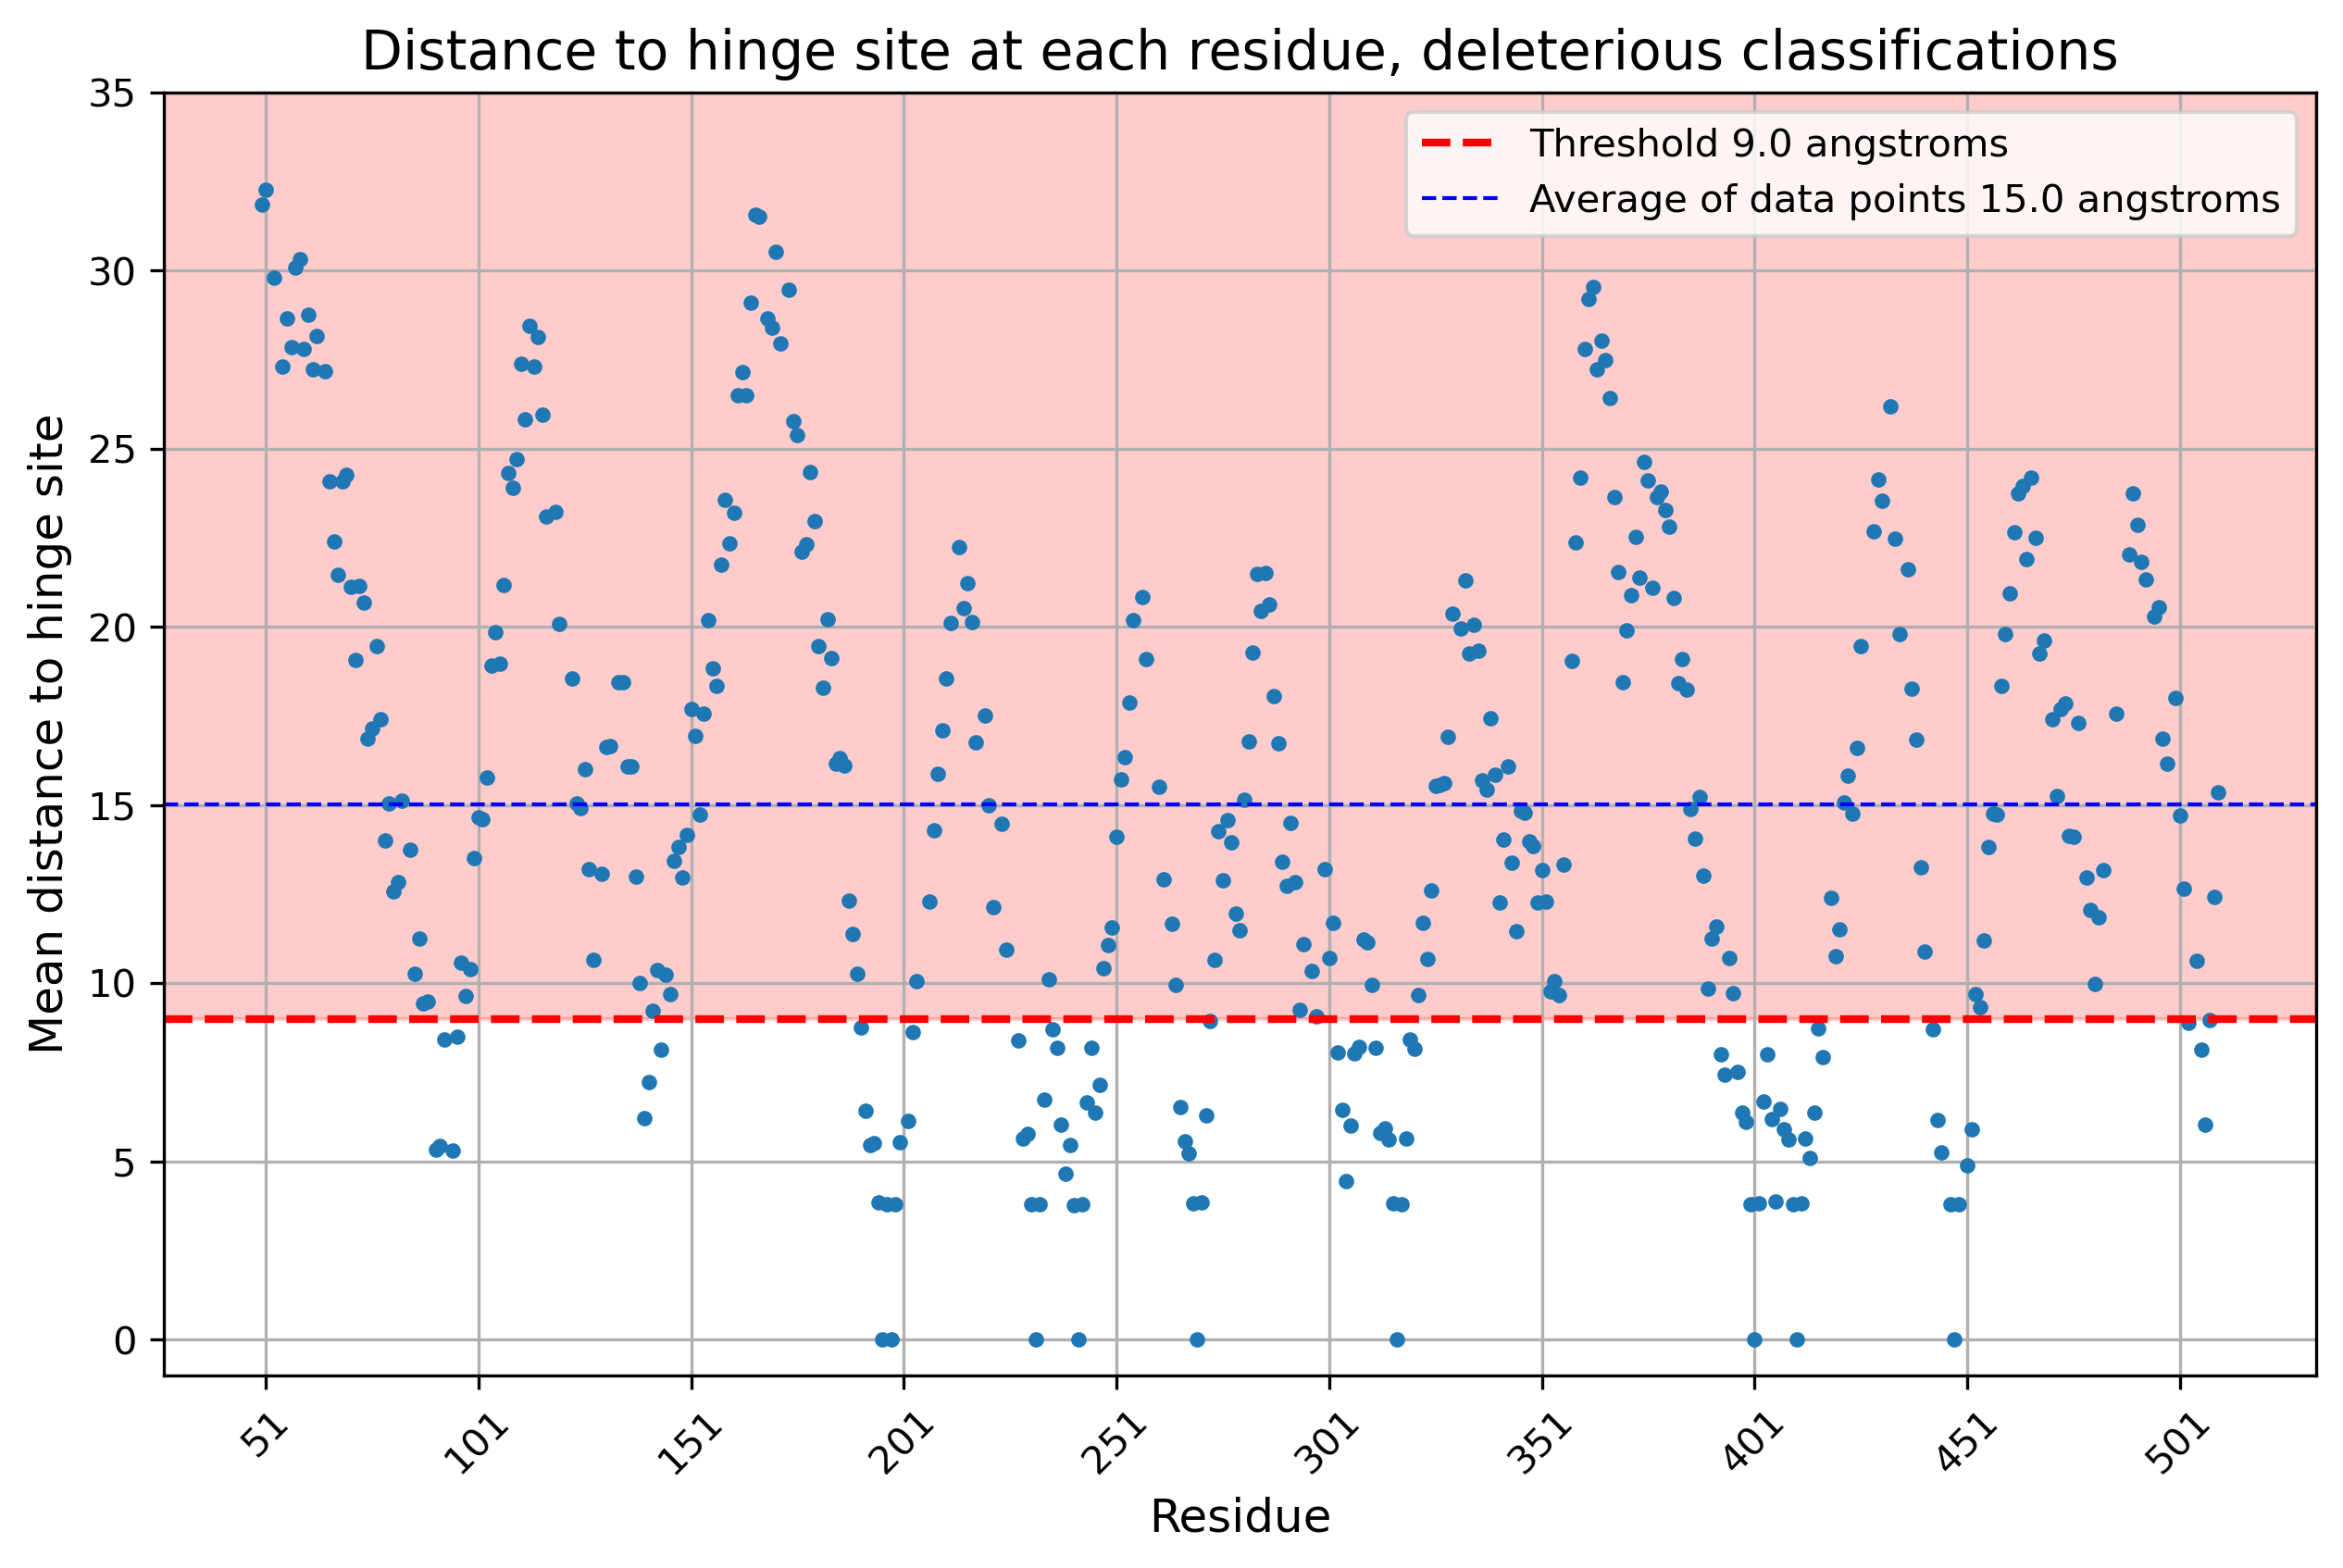

In [26]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["Mindist_hinge"],'.')
# Cutoff horizontal line
plt.axhline(y=9.0, color="red", linestyle="--", linewidth=2,label="Threshold 9.0 angstroms")
plt.axhline(y=15.009524330636145, color="blue",linestyle="--",linewidth=1,label="Average of data points 15.0 angstroms")
plt.axhspan(9.0,50, color="red", alpha=0.2)
plt.ylim(-1,35)

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean distance to hinge site", fontsize=12)
plt.title("Distance to hinge site at each residue, deleterious classifications", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid(True)
plt.legend()
plt.show()

In [27]:
grouped_data = ds_calc.groupby("Residue", as_index=False)["RSA"].mean()
true_deleterious_RSA = grouped_data[grouped_data["RSA"] <= 0.273]

grouped_data = ds_calc.groupby("Residue", as_index=False)["Foldx_energy"].mean()
true_deleterious_Foldx = grouped_data[grouped_data["Foldx_energy"] >= 1.15]

grouped_data = ds_calc.groupby("Residue", as_index=False)["Mindist_bindingsiteA"].mean()
true_deleterious_binding_distance = grouped_data[grouped_data["Mindist_bindingsiteA"] <= 13.0]

grouped_data = ds_calc.groupby("Residue", as_index=False)["Mindist_hinge"].mean()
true_deleterious_hinge_distance = grouped_data[grouped_data["Mindist_hinge"] <= 9.0]

In [28]:
set_rsa_true = set(true_deleterious_RSA["Residue"])
set_foldx_true = set(true_deleterious_Foldx["Residue"])
set_binding_distance_true = set(true_deleterious_binding_distance["Residue"])
set_hinge_distance_true = set(true_deleterious_hinge_distance["Residue"])

In [29]:
grouped_data = ds_calc.groupby("Residue", as_index=False)["RSA"].mean()
false_deleterious_RSA = grouped_data[grouped_data["RSA"] >= 0.273]

grouped_data = ds_calc.groupby("Residue", as_index=False)["Foldx_energy"].mean()
false_deleterious_Foldx = grouped_data[grouped_data["Foldx_energy"] <= 1.15]

grouped_data = ds_calc.groupby("Residue", as_index=False)["Mindist_bindingsiteA"].mean()
false_deleterious_binding = grouped_data[grouped_data["Mindist_bindingsiteA"] >= 13.0]

grouped_data = ds_calc.groupby("Residue", as_index=False)["Mindist_hinge"].mean()
false_deleterious_hinge = grouped_data[grouped_data["Mindist_hinge"] >= 9.0]

In [30]:
set_rsa_false = set(false_deleterious_RSA["Residue"])
set_foldx_false = set(false_deleterious_Foldx["Residue"])
set_binding_distance_false = set(false_deleterious_binding["Residue"])
set_hinge_distance_false = set(false_deleterious_hinge["Residue"])

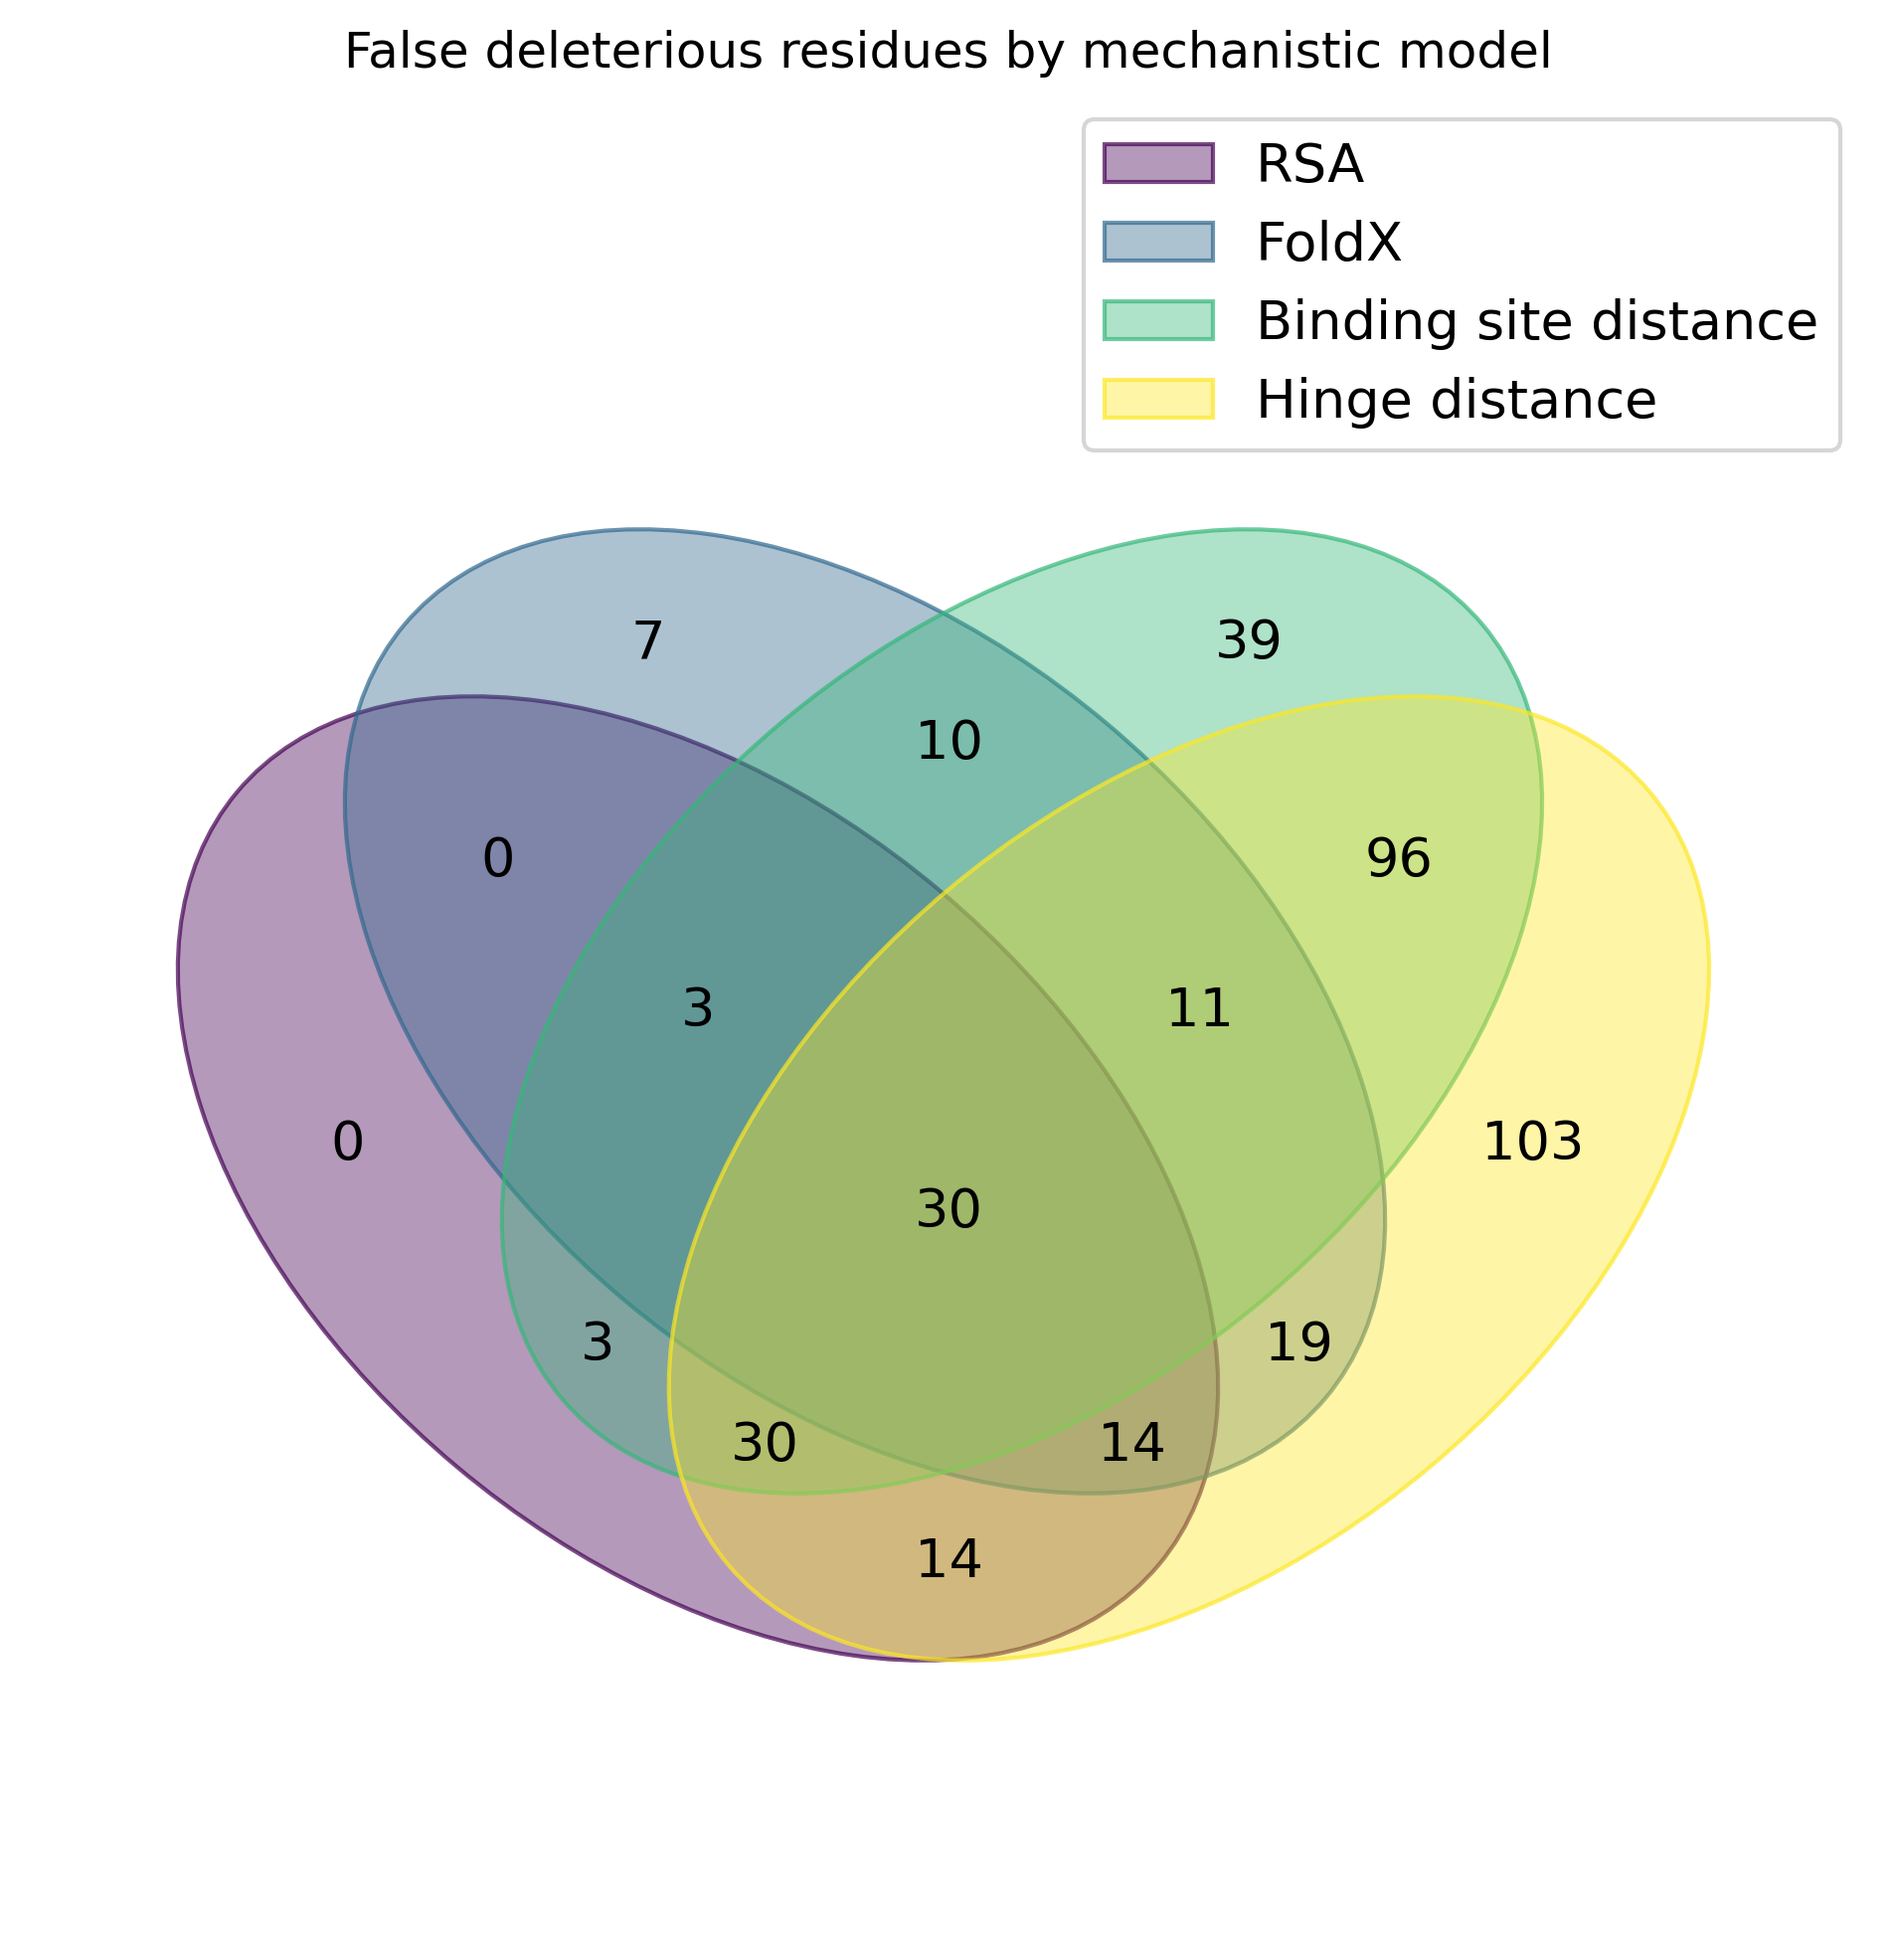

In [31]:
import venn
data = {
    'RSA': set_rsa_false,
    'FoldX': set_foldx_false,
    'Binding site distance': set_binding_distance_false,
    'Hinge distance': set_hinge_distance_false
}

ax = venn.venn(data)
plt.title("False deleterious residues by mechanistic model")
plt.show()

This is saying there are two residues which are falsely labeled as deleterious according to all four predictors i.e. they are likely captured by some other mechanistic model which we haven't considered.

### Middle of Venn diagram

In [32]:
residues_4order = set_rsa_false & set_foldx_false & set_binding_distance_false & set_hinge_distance_false
residues_4order = np.array(sorted(residues_4order))
print(residues_4order)

[ 56  59  61  65  66  71  77  80  85  87 108 109 115 125 131 134 224 287
 292 309 457 460 462 466 467 483 496 498 505 510]


### Three overlapping sets

In [33]:
rsa_foldx_binding = (set_rsa_false & set_foldx_false & set_binding_distance_false) - set_hinge_distance_false

rsa_foldx_hinge = (set_rsa_false & set_foldx_false & set_hinge_distance_false) - set_binding_distance_false

rsa_binding_hinge = (set_rsa_false & set_binding_distance_false & set_hinge_distance_false) - set_foldx_false

foldx_binding_hinge = (set_foldx_false & set_binding_distance_false & set_hinge_distance_false) - set_rsa_false

In [34]:
residues_3order = (rsa_foldx_binding | rsa_foldx_hinge | rsa_binding_hinge | foldx_binding_hinge)
residues_3order = np.array(sorted(residues_3order))
print(residues_3order)
len(residues_3order)

[ 50  57  58  75  76 111 114 126 130 137 164 166 171 178 179 187 209 212
 216 220 249 253 254 264 286 288 291 295 300 301 302 306 326 334 360 364
 365 366 371 373 391 425 437 447 451 461 464 465 473 474 477 479 481 489
 490 493 495 502]


58

### Two overlapping sets

In [35]:
rsa_foldx = (set_rsa_false & set_foldx_false) - (set_binding_distance_false | set_hinge_distance_false)

rsa_binding = (set_rsa_false & set_binding_distance_false) - (set_foldx_false | set_hinge_distance_false)

rsa_hinge = (set_rsa_false & set_hinge_distance_false) - (set_foldx_false | set_binding_distance_false)

foldx_binding = (set_foldx_false & set_binding_distance_false) - (set_rsa_false | set_hinge_distance_false)

foldx_hinge = (set_foldx_false & set_hinge_distance_false) - (set_rsa_false | set_binding_distance_false)

binding_hinge = (set_binding_distance_false & set_hinge_distance_false) - (set_rsa_false | set_foldx_false)

In [36]:
residues_2order = (rsa_foldx | rsa_binding | rsa_hinge | foldx_binding | foldx_hinge | binding_hinge)
residues_2order = np.array(sorted(residues_2order))
print(residues_2order)
len(residues_2order)

[ 51  53  55  60  62  63  67  70  72  73  74  78  82  83  86  88  89  98
 113 123 127 128 132 135 136 138 143 147 148 151 163 165 169 170 172 174
 176 183 184 188 196 202 204 207 208 210 211 214 215 217 218 221 222 225
 246 248 250 251 252 255 257 258 261 262 265 267 278 283 284 290 294 297
 298 303 304 307 310 313 320 322 323 324 325 327 328 329 330 332 333 340
 346 351 353 355 361 362 363 370 372 375 387 388 389 390 392 395 396 399
 419 420 421 422 423 424 431 433 435 439 440 441 443 444 448 455 456 458
 459 463 468 469 471 475 476 480 482 486 491 492 497 500 501 509]


142

### In a single set only

In [37]:
only_rsa = set_rsa_false - (set_foldx_false | set_binding_distance_false | set_hinge_distance_false)

only_foldx = set_foldx_false - (set_rsa_false | set_binding_distance_false | set_hinge_distance_false)

only_binding = set_binding_distance_false - (set_rsa_false | set_foldx_false | set_hinge_distance_false)

only_hinge = set_hinge_distance_false - (set_rsa_false | set_foldx_false | set_binding_distance_false)

In [38]:
residues_1order = (only_rsa | only_foldx | only_binding | only_hinge)
residues_1order = np.array(sorted(residues_1order))
print(residues_1order)
len(residues_1order)

[ 68  69  79  81  91  92  93  95  97  99 100 101 102 103 104 105 106 107
 110 112 116 117 119 120 124 139 142 145 146 149 150 152 153 154 155 156
 157 158 159 160 161 162 167 175 177 180 181 182 185 186 189 190 197 198
 199 200 203 228 229 230 234 235 240 243 244 245 247 266 268 269 270 271
 273 274 275 276 277 279 280 281 282 285 289 293 305 308 311 318 319 321
 335 336 337 338 339 341 342 343 344 345 347 348 349 350 352 354 356 358
 359 367 368 369 374 376 377 378 379 380 381 382 383 384 385 386 393 394
 398 400 402 404 413 414 415 416 417 426 429 430 434 438 445 449 453 454
 472 503 506 507 508]


149

### In no sets at all

In [39]:
residues_1_2 = np.union1d(residues_1order, residues_2order)
residues_1_2_3 = np.union1d(residues_1_2, residues_3order)
residues_1_2_3_4 = np.union1d(residues_1_2_3, residues_4order)

all_residues_array = ds_calc["Residue"].to_numpy()
residues_0order = np.setdiff1d(all_residues_array, residues_1_2_3_4)

In [40]:
residues_0order = np.array(sorted(residues_0order))
print(residues_0order)
len(residues_0order)

[ 96 140 141 144 191 192 193 194 195 231 232 233 236 237 238 239 241 242
 272 312 314 315 316 317 397 401 403 405 406 407 408 409 410 411 412 452]


36

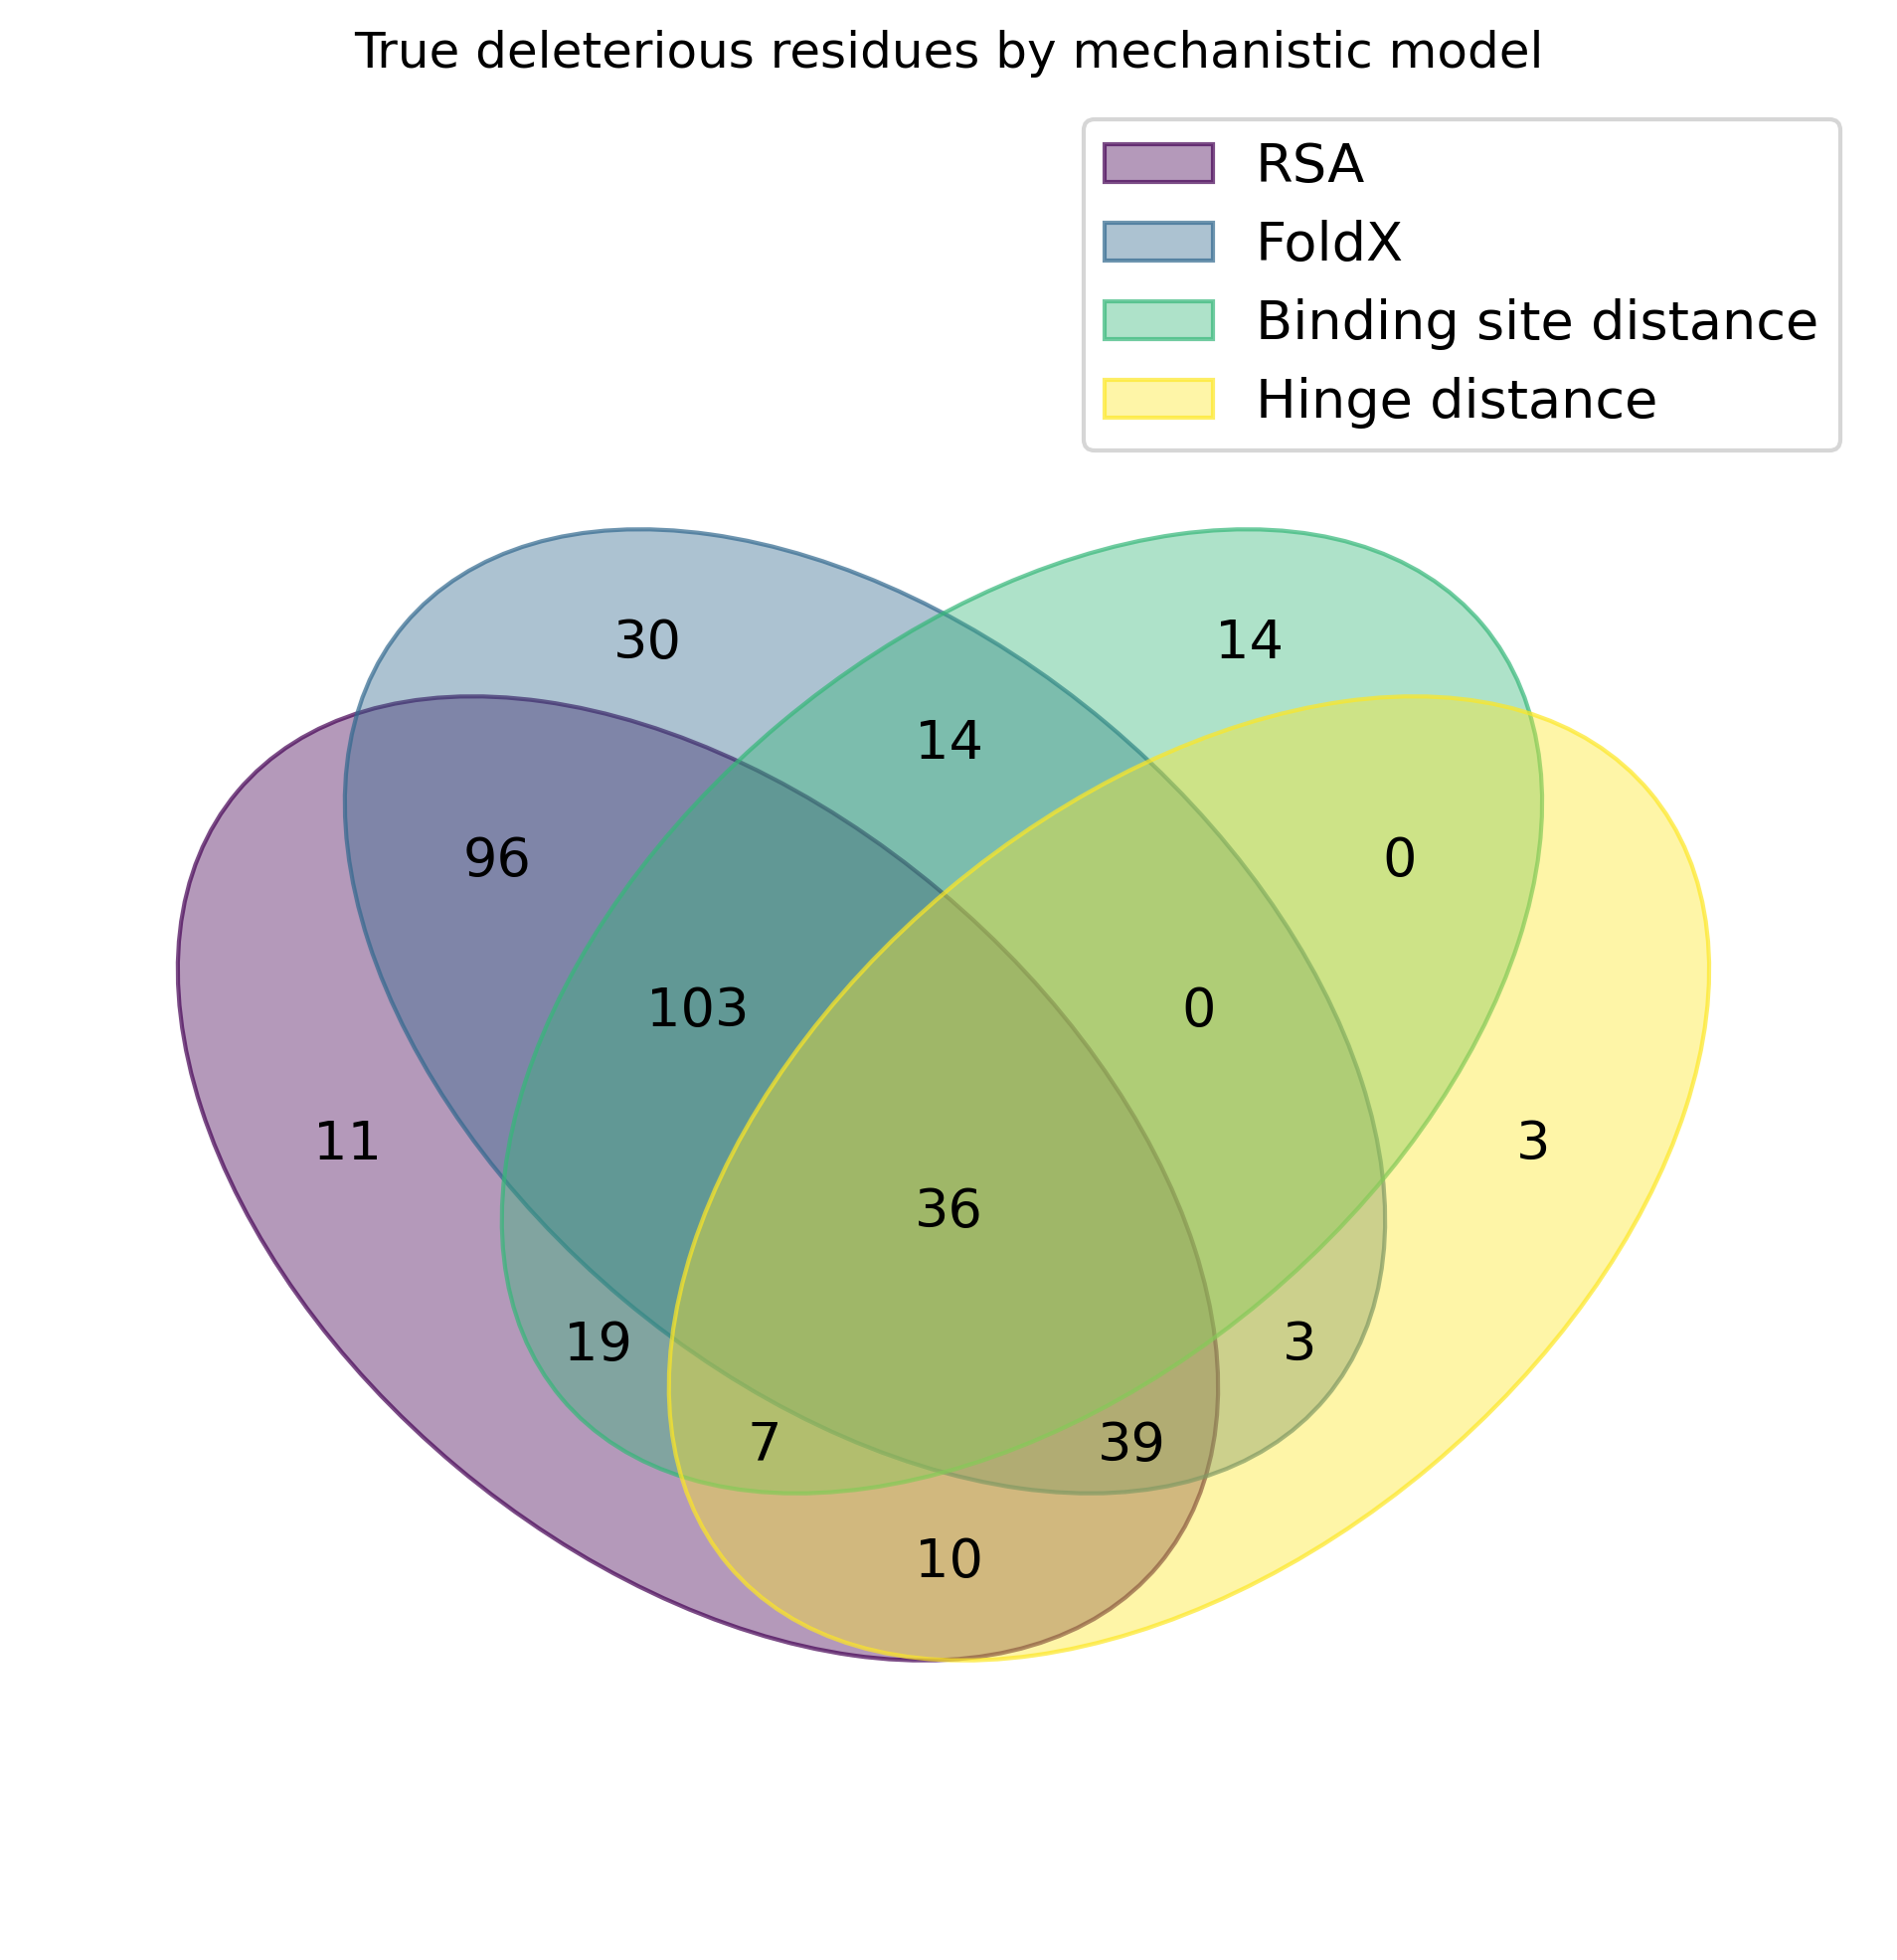

In [41]:
import venn
data = {
    'RSA': set_rsa_true,
    'FoldX': set_foldx_true,
    'Binding site distance': set_binding_distance_true,
    'Hinge distance': set_hinge_distance_true
}

ax = venn.venn(data)
plt.title("True deleterious residues by mechanistic model")
plt.show()

What does this mean? I will need some help wrapping my head around this one...

Starting from the middle. Mutations on 60 residues are correctly classified as deleterious by all four predictors. So these 60 residues must be extremely easy to predict functionality of. We can see what those 60 residues are probably...

### Middle of Venn diagram (very easy to classify, all predictors agree)

In [42]:
residues_4order = set_rsa_true & set_foldx_true & set_binding_distance_true & set_hinge_distance_true
residues_4order = np.array(sorted(residues_4order))
print(residues_4order)

[ 96 140 141 144 191 192 193 194 195 231 232 233 236 237 238 239 241 242
 272 312 314 315 316 317 397 401 403 405 406 407 408 409 410 411 412 452]


### Three overlapping sets (still easy to classify, still some uncertainty)

In [43]:
rsa_foldx_binding = (set_rsa_true & set_foldx_true & set_binding_distance_true) - set_hinge_distance_true

rsa_foldx_hinge = (set_rsa_true & set_foldx_true & set_hinge_distance_true) - set_binding_distance_true

rsa_binding_hinge = (set_rsa_true & set_binding_distance_true & set_hinge_distance_true) - set_foldx_true

foldx_binding_hinge = (set_foldx_true & set_binding_distance_true & set_hinge_distance_true) - set_rsa_true

In [44]:
residues_3order = (rsa_foldx_binding | rsa_foldx_hinge | rsa_binding_hinge | foldx_binding_hinge)
residues_3order = np.array(sorted(residues_3order))
print(residues_3order)
len(residues_3order)

[ 68  69  79  81  91  92  93  95  97  99 100 101 102 103 104 105 106 107
 110 112 116 117 119 120 124 139 142 145 146 149 150 152 153 154 155 156
 157 158 159 160 161 162 167 175 177 180 181 182 185 186 189 190 197 198
 199 200 203 228 229 230 234 235 240 243 244 245 247 266 268 269 270 271
 273 274 275 276 277 279 280 281 282 285 289 293 305 308 311 318 319 321
 335 336 337 338 339 341 342 343 344 345 347 348 349 350 352 354 356 358
 359 367 368 369 374 376 377 378 379 380 381 382 383 384 385 386 393 394
 398 400 402 404 413 414 415 416 417 426 429 430 434 438 445 449 453 454
 472 503 506 507 508]


149

### Two overlapping sets (some uncertainty)

In [45]:
rsa_foldx = (set_rsa_true & set_foldx_true) - (set_binding_distance_true | set_hinge_distance_true)

rsa_binding = (set_rsa_true & set_binding_distance_true) - (set_foldx_true | set_hinge_distance_true)

rsa_hinge = (set_rsa_true & set_hinge_distance_true) - (set_foldx_true | set_binding_distance_true)

foldx_binding = (set_foldx_true & set_binding_distance_true) - (set_rsa_true | set_hinge_distance_true)

foldx_hinge = (set_foldx_true & set_hinge_distance_true) - (set_rsa_true | set_binding_distance_true)

binding_hinge = (set_binding_distance_true & set_hinge_distance_true) - (set_rsa_true | set_foldx_true)

In [46]:
residues_2order = (rsa_foldx | rsa_binding | rsa_hinge | foldx_binding | foldx_hinge | binding_hinge)
residues_2order = np.array(sorted(residues_2order))
print(residues_2order)
len(residues_2order)

[ 51  53  55  60  62  63  67  70  72  73  74  78  82  83  86  88  89  98
 113 123 127 128 132 135 136 138 143 147 148 151 163 165 169 170 172 174
 176 183 184 188 196 202 204 207 208 210 211 214 215 217 218 221 222 225
 246 248 250 251 252 255 257 258 261 262 265 267 278 283 284 290 294 297
 298 303 304 307 310 313 320 322 323 324 325 327 328 329 330 332 333 340
 346 351 353 355 361 362 363 370 372 375 387 388 389 390 392 395 396 399
 419 420 421 422 423 424 431 433 435 439 440 441 443 444 448 455 456 458
 459 463 468 469 471 475 476 480 482 486 491 492 497 500 501 509]


142

### In a single set only (very uncertain)

In [47]:
only_rsa = set_rsa_true - (set_foldx_true | set_binding_distance_true | set_hinge_distance_true)

only_foldx = set_foldx_true - (set_rsa_true | set_binding_distance_true | set_hinge_distance_true)

only_binding = set_binding_distance_true - (set_rsa_true | set_foldx_true | set_hinge_distance_true)

only_hinge = set_hinge_distance_true - (set_rsa_true | set_foldx_true | set_binding_distance_true)

In [48]:
residues_1order = (only_rsa | only_foldx | only_binding | only_hinge)
residues_1order = np.array(sorted(residues_1order))
print(residues_1order)
len(residues_1order)

[ 50  57  58  75  76 111 114 126 130 137 164 166 171 178 179 187 209 212
 216 220 249 253 254 264 286 288 291 295 300 301 302 306 326 334 360 364
 365 366 371 373 391 425 437 447 451 461 464 465 473 474 477 479 481 489
 490 493 495 502]


58

### In no sets at all

In [49]:
residues_1_2 = np.union1d(residues_1order, residues_2order)
residues_1_2_3 = np.union1d(residues_1_2, residues_3order)
residues_1_2_3_4 = np.union1d(residues_1_2_3, residues_4order)

all_residues_array = ds_calc["Residue"].to_numpy()
residues_0order = np.setdiff1d(all_residues_array, residues_1_2_3_4)

In [50]:
residues_0order = np.array(sorted(residues_0order))
print(residues_0order)
len(residues_0order)

[ 56  59  61  65  66  71  77  80  85  87 108 109 115 125 131 134 224 287
 292 309 457 460 462 466 467 483 496 498 505 510]


30